# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import emcee
from astropy.table import Table, join
import illustris_python as il
from astropy.table import setdiff
import time as time
import scipy.signal as signal
import scipy.interpolate as interpolate
from astropy.cosmology import Planck15 as cosmo
from astropy.table import vstack
import h5py
import matplotlib.gridspec as gridspec
from IPython.core.display import display, HTML
from astropy.cosmology import Planck15 as cosmo
import pickle
import corner
import sys

/tmp/ipykernel_3509/1315126351.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Plotting preferences
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],})
plt.rcParams['figure.facecolor'] = 'white'


# File Loading

In [9]:
# Loads in specified files. If 1 number is passed in, returns the halo_table and subhalo_table directly. Multiple numbers - returns arrays of said tables.
def load_files(snapshot_list):
    if(len(snapshot_list)==0):
        return None
    
    elif(len(snapshot_list)==1):
        halo_table = Table.read('CutSnapshots/Halo_snapshot'+str(snapshot_list[0])+'.fits', format='fits')
        subhalo_table = Table.read('CutSnapshots/Subhalo_snapshot'+str(snapshot_list[0])+'.fits', format='fits')
        headers = pickle.load(open("headers.pickle", "rb"))
        return halo_table, subhalo_table, headers
    
    halo_tables = []
    subhalo_tables = []
    for i in range(0, len(snapshot_list)):
        halo_tables.append(Table.read('CutSnapshots/Halo_snapshot'+str(snapshot_list[i])+'.fits', format='fits'))
        subhalo_tables.append(Table.read('CutSnapshots/Subhalo_snapshot'+str(snapshot_list[i])+'.fits', format='fits'))
    
    headers = pickle.load(open("headers.pickle", "rb"))
        
    return halo_tables, subhalo_tables, headers

# CURRENTLY UNUSED FUNCTION TO DETERMINE RHO_G VALUES (BACKGROUND GALAXY DENSITY) FOR GIVEN SUBHALO POPULATION:
def get_rho(subhalo_table_cut, boxsize):
    return len(subhalo_table_cut)/(boxsize*.001)**3


# Profiles

## Profile Helper Functions

In [11]:
# SAVITSKY-GOLAY FUNCTION FOR INITIAL LOG DERIVATIV PLOTTING:
def get_slope_sg(xx, yy, num_output,w,p):
    # Savitsky-Golay smoothing                                                                                                                                        
    window_size = w
    poly_order = p
    yy_filtered = signal.savgol_filter(np.log(yy), window_size, poly_order)
    # fit spline                                                                                                                                                      
    yy_spline = interpolate.interp1d(np.log(xx), yy_filtered, kind = 'cubic')
    # Evaluate spline on very fine grid                                                                                                                                
    numsmooth = 1000
    lnxx_fine = np.linspace(np.log(np.min(xx)), np.log(np.max(xx)), num = numsmooth)
    lnyy_fine = yy_spline(lnxx_fine)
    yy_fine = np.exp(lnyy_fine)
    # Calculate derivative using finite differences                                                                                                                    
    dlny_dlnx_fine = (lnyy_fine[1:] - lnyy_fine[:-1])/(lnxx_fine[1:] - lnxx_fine[:-1])
    # Interpolate derivative onto desired array                                                                                                                        
    interp_func = interpolate.interp1d(lnxx_fine[:-1], dlny_dlnx_fine)
    lnxx_out = np.linspace(np.min(lnxx_fine[:-1]), np.max(lnxx_fine[:-1]), num = num_output)
    dlny_dlnx_out = interp_func(lnxx_out)
    return np.exp(lnxx_out), dlny_dlnx_out, yy_fine, np.exp(lnxx_fine)

# NUMBER DENSITY PROFILE FUNCTIONS:
def ND_Profile_3D(RScale,Rmin,Rmax,bins,r_subhalo): #DensityProfileMulti    
    # PREPARING RADII VALUES TO CALCULATE DENSITY
    bin_edge = RScale*np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1) #3.5 earlier
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]

    ND = np.zeros((1, bins))
    
    GALAXIES = np.zeros((1, bins))
    
    # LOOPING THROUGH RADII, CALCULATING NUMBER DENSITY
    for i in range(0,bins):
        mask_sep = (r_subhalo >=bin_min[i])&(r_subhalo < bin_max[i])
        delta_r = bin_max[i] - bin_min[i]
        volume = (4/3)*np.pi*(((bin_max[i])**3) - ((bin_min[i])**3))
        
        for j in range(0,1):
            number_j = len(r_subhalo[mask_sep])
            density_j = number_j/volume
            ND[j,i] = (density_j)
            GALAXIES[j,i] = (number_j)
            
    return ND, GALAXIES

def ND_Profile_2D(RScale,Rmin,Rmax,bins,r_subhalo): 
    # PREPARING RADII VALUES TO CALCULATE DENSITY
    bin_edge = RScale*np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1)
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]

    ND = np.zeros((1, bins))
    
    GALAXIES = np.zeros((1, bins))
    
    # LOOPING THROUGH RADII, CALCULATING NUMBER DENSITY
    for i in range(0,bins):
        mask_sep = (r_subhalo >=bin_min[i])&(r_subhalo < bin_max[i])
        delta_r = bin_max[i] - bin_min[i]
        area = np.pi*(((bin_max[i])**2) - ((bin_min[i])**2))
        #volume = (4/3)*np.pi*(((bin_max[i])**3) - ((bin_min[i])**3)) # MY ORIGINAL CODE HAD THIS FOR 2D TOO BUT I THINK IT WAS AN ERROR
        
        for j in range(0,1):
            number_j = len(r_subhalo[mask_sep])
            density_j = number_j/area#volume
            ND[j,i] = (density_j)
            GALAXIES[j,i] = (number_j)
            
    return ND, GALAXIES


## Main Profile Class

In [12]:
# CLASS FOR CALCULATING THE PROFILES
class MultiProfiles:
    def __init__(self, header, cut, N, subhalo_table_m, halo_grp, CM_coords, Halo_Array, DIM):
        # SAVITSKY-GOLAY PARAMETERS:
        w = 9
        p = 5
        
        # RADIAL BIN PREFERENCES:
        bins = 20
        Rmin = 0.1
        Rmax = 7

        redshift = header['Redshift']
        boxsize = header['BoxSize'] #kpc/h
        scale_factor = header['Time']
        box_bounds = boxsize*np.ones(3)#*conv_fac

        ND_LIST = []
        ND_BOOT = []
        RSCALE_LIST = []

        
        # LOOPING THROUGH CLUSTERS:
        for h_i1 in Halo_Array:
            N_subhalos = halo_grp['GroupNsubs'][h_i1]
            R200m = .001*scale_factor*halo_grp['Group_R_Mean200'][h_i1] #Mpc/h
            RScale = R200m
            RSCALE_LIST.append(RScale)
            CM_halo = halo_grp['GroupPos'][h_i1]
            
            # COORDINATES OF GALAXIES WITH ORIGIN AT CLUSTER CENTER:
            dev = np.array(CM_coords-CM_halo) # Has all subhalos > mass cut
            # ACCOUNTING FOR CONTINUOUS BOUNDARY CONDITION AT BOX EDGE:
            for ind, q in enumerate(dev.T):
                q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
                dev.T[ind] = q
            rmax = (Rmax*R200m)
            
            # FOR CLUSTER i, CALCULATE PROFILE:
            
            # 3D PROFILE:
            if DIM == 3:
                r_subhalo_all = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h

                # TAKING GALAXIES IN RADIUS OF HALO CENTER
                r_subhalo_hi = r_subhalo_all[r_subhalo_all<=rmax]
                subhalo_table_hi = subhalo_table_m[r_subhalo_all<=rmax]
                ND, GAL = ND_Profile_3D(RScale, Rmin,Rmax,bins,r_subhalo_hi)
                label_list, plot_color_list, title = ['All'], ['maroon'], 'All'

            
            # 2D PROFILE
            elif DIM == 2:
                #PROJECTED 2D PROFILE:
                h_max = 60
                r_subhalo_proj_all = np.linalg.norm(dev[:,0:2], axis = 1)*.001*scale_factor #np.sqrt(dev[:,0]**2 + dev[:,1]**2) # R distance projected along z direction
                r_subhalo_proj_hi = r_subhalo_proj_all[(r_subhalo_proj_all<=rmax)&(dev[:,2]<h_max) & (dev[:,2]>-h_max)] # All within rmax of cluster and within h_min and h_max in z
                ND, GAL = ND_Profile_2D(RScale, Rmin,Rmax,bins,r_subhalo_proj_hi)
                label_list, plot_color_list, title = ['All'], ['teal'], 'All'

            ND_LIST.append(ND)
            

        # RADIAL BINS, R_AVG, ETC FOR STACKED CLUSTERS:
        R_avg = np.mean(RSCALE_LIST) #Mpc/h
        print("R_avg:", R_avg)
        bin_divided = np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1)
        bin_stack = R_avg*(bin_divided[1:]+bin_divided[:-1])/2

        Yi_avg_list = []
        cov_list = []
        jack_err_list = []
        plt.figure(figsize=(10,10))
        ax0 = plt.subplot(2,1,1)
        ax1 = plt.subplot(2,1,2)
        plt.tight_layout()
        
        # STACK CLUSTER PROFILES AND CALCULATE JACKKNIFE ERROR OF STACKING:
        N_halo = len(Halo_Array)
        for i in range(0,N):
            # JACKKNIFE ERROR:
            rho_mat = np.array(ND_LIST)[:,i,:]
            # Compute mean density profile
            averaged_rho = np.nanmean(rho_mat, axis=0)
            # Compute JK Covariance Matrix
            cov = np.zeros((bins, bins))
            for k in range(N_halo):
                rho_k = rho_mat[k]
                for l in range(bins):
                    for j in range(bins):
                        cov[l][j] += (rho_k[l]-averaged_rho[l])*(rho_k[j]-averaged_rho[j])
            cov /= N_halo*(N_halo-1)
            jack_err = np.sqrt(np.diag(cov))
            Yi_avg = averaged_rho
            Yi_avg_list.append(Yi_avg)
            cov_list.append(cov)
            jack_err_list.append(jack_err)
            
            # CALCULATING ROUGH LOG DERIVATIVE WITH SAVITSKY-GOLAY FOR PLOTTING:
            dlog_data_SG_x1, dlog_data_SG_y1, yy_fine1, xx_fine1 = get_slope_sg(bin_stack, (Yi_avg), 1000,w,p)  
            
            # PLOTTING STACK:
            ax0.errorbar(bin_stack, Yi_avg, yerr = jack_err, c = plot_color_list[i], lw = 3, ecolor = plot_color_list[i], elinewidth = 3, capsize=3, label = label_list[i])
            ax0.set_xscale('log')
            ax0.set_yscale('log')
            ax0.set_xlabel('R (Mpc/h)')
            ax0.set_ylabel('Galaxy Number Density')
            ax0.legend()
            ax1.plot(dlog_data_SG_x1, dlog_data_SG_y1, c = plot_color_list[i])
            ax1.set_xscale('log')
            ax1.set_xlabel('R (Mpc/h)')
            ax1.set_ylabel('dlog of Number Density')
        plt.show()
        
        # SAVING VALUES:
        self.ND_LIST = ND_LIST
        self.bin_stack = bin_stack
        self.Yi_avg_list = Yi_avg_list
        self.cov_list = cov_list
        self.boot_err_list = jack_err_list
        self.R_avg = R_avg
        self.title = title
        

## MCMC Functions

In [13]:
# FUNCTIONS FOR FITTING PROFILES USING MCMC:

r_0 = 1.5 # Fix r_0 to 1.5 Mpc/h

def rho_DK14(theta, r, rho_g_i):
    """
    Definition of halo profile model from Diemer Kravstov 2014
    r_s, r_t, r must all be in units of kpc/h
    """
    
    lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = theta
    alpha = 10.**lg_alpha
    beta = 10.**lg_beta
    gamma = 10.**lg_gamma
    r_s = 10.**lg_r_s
    r_t = 10.**lg_r_t
    rho_s = 10**lg_rho_s
    rho_0 = 10**lg_rho_0
    
    
    def rho_inner(r):
        exp_arg = -2/alpha*(((r/r_s)**alpha)-1)
        return rho_s*np.exp(exp_arg)

    def rho_outer(r):
        Tau = 20
        return rho_0*(((1/Tau)+((r/r_0)**(s_e)))**(-1)) + rho_g_i

    def f_trans(r):
        return (1+(r/r_t)**beta)**(-gamma/beta)
    
    return rho_inner(r)*f_trans(r)+rho_outer(r)

    
def ln_like3d(theta,  r_data, rho_data, cov, rho_g_i,blue):
    """
    Definition of log-likelihood using DK14 model
    """
    
    rho_thr = rho_DK14(theta, r_data, rho_g_i)
    diff = rho_data-rho_thr
    
    likelihood = -1/2 * np.dot(diff, np.linalg.solve(cov, diff))
    
    if (np.isnan(likelihood)==True):
        return -np.inf

    return likelihood


def ln_prior(theta,blue):
    """
    Definition of parameter priors
    """

    lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = theta
    alpha = 10.**lg_alpha
    beta = 10.**lg_beta
    gamma = 10.**lg_gamma
    r_s = 10.**lg_r_s
    r_t = 10.**lg_r_t
    rho_s = 10**lg_rho_s
    rho_0 = 10**lg_rho_0
    
    
    # Top hat prior on r_s, r_t, s_e
    r_s_check = (r_s > 0.1) & (r_s < 5)
    r_t_check = (r_t > 0.1) & (r_t < 5)
    s_e_check = (s_e > .1) & (s_e < 10)

    rho_s_check = True
    rho_0_check = True

    flat_prior_check = r_s_check & r_t_check & s_e_check & rho_s_check & rho_0_check 
    
    if not flat_prior_check:
        return -np.inf

    return  -0.5*(lg_alpha - np.log10(0.22))**2/0.6**2 - 0.5*(lg_beta - np.log10(6.0))**2/0.2**2 - 0.5*(lg_gamma - np.log10(4.0))**2/0.2**2
    

def ln_prob3d(theta, r, rho, cov, rho_g_i,blue):
    """
    Total probability definition (likelihood+prior)
    """
    lp = ln_prior(theta,blue)
    
    if not np.isfinite(lp):
        return -np.inf

    return lp+ln_like3d(theta, r, rho, cov, rho_g_i,blue)


def main(p0,n_walkers,n_iter,n_dim,n_burn,ln_prob, data):
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_prob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, n_burn, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, n_iter, progress=True)

    return sampler, pos, prob, state

def MCMC(averaged_r_tot, profiles, covs,rho_g_list,blue_list,init_theta_list, bounds, n_burn, n_walkers, n_iter):
    labels = [r'$\log(\alpha)$', r'$\log(\beta)$', r'$\log(\gamma)$', r'$\log(r_s)$', r'$\log(r_t)$', r'$\log(\rho_s)$', r'$\log(\rho_0)$', r'$s_e$']
    best_fit_mcmc_list = []
    samples_list = []
    sampler_list = []
    for i in range(len(profiles)):
        averaged_r_tot = averaged_r_tot #in Mpc/h
        averaged_rho_tot = profiles[i] 
        rho_g_i = rho_g_list[i]
        cov = covs[i]
        init_theta = init_theta_list[i]
        if blue_list[i] == True:
            blue = True
        else:
            blue = False
        # Fit TNG_300-1 Profiles
        data = [averaged_r_tot, averaged_rho_tot, cov,rho_g_i,blue]
        args = (averaged_r_tot, averaged_rho_tot, cov,rho_g_i,blue)
        # Set initial guess and boundaries and use minimization to determine start position of MCMC chain
        ndim = 8 #number of free parameters
        neg_ll3d = lambda *args: -ln_like3d(*args)

        res = scipy.optimize.minimize(neg_ll3d, init_theta, args=args, method='SLSQP', options = {'maxiter':500}, bounds=bounds)

        # Run MCMC
        n_burn = n_burn
        n_dim, n_walkers = 8, n_walkers
        n_iter = n_iter
        p0 = [res.x + 1e-3*np.random.randn(n_dim) for i in range(n_walkers)]
        sampler, pos, prob, state = main(p0, n_walkers, n_iter, n_dim, n_burn,ln_prob3d, data)
        samples = sampler.flatchain
        corner.corner(samples, labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True);
        samples_list.append(samples)
        best_fit_mcmc_list.append(samples[np.argmax(sampler.flatlnprobability)])
        sampler_list.append(sampler)

    print('done MCMC')
    return best_fit_mcmc_list, samples_list, sampler_list

# FUNCTION FOR PLOTTING FITTED PROFILES
def FittedPlots(halo_array_masked, halo_grp, best_fit_mcmc_list_DF, profiles, averaged_r_tot,Ravg,covs,rho_g_list,sigs,labels, colors, ls_list):
    '''
    fig, ax = plt.subplots(3,1,figsize=(10,17))
    ax0 = ax[0]
    ax1 = ax[1]
    ax2 = ax[2]
    '''
    plt.figure(figsize=(9,11))
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    
    plt.tight_layout()
    halo_masses = []
    for h_i in halo_array_masked:
        halo_masses.append(halo_grp['GroupMass'][h_i]*1e10)
    r_sp_list = []
    r_sp_r200_list = []
    alpha_list = []
    bins = 20
    for i in range(len(colors)):#(1,2):#
        best_fit_mcmc = best_fit_mcmc_list_DF[i]
        averaged_rho_tot = profiles[i]
        r_thr = np.logspace(np.log10(np.min(averaged_r_tot)), np.log10(np.max(averaged_r_tot)), 3000)
        fit = rho_DK14(best_fit_mcmc,r_thr, rho_g_list[i]) - rho_g_list[i]
        log_deriv_mcmc = r_thr/fit*np.gradient(fit, r_thr)
        r_sp = r_thr[np.argmin(log_deriv_mcmc)]
        r_sp_r200 = r_sp/Ravg
        r_sp_list.append(r_sp)
        r_sp_r200_list.append(r_sp_r200)
        alpha_list.append(10**best_fit_mcmc[0])
        
        Min = min(averaged_r_tot)/Ravg
        Max = max(averaged_r_tot)/Ravg
        ax1.plot(r_thr/Ravg, fit, color=colors[i], linestyle=ls_list[i] 
                 , label="Model Fit %s" %(labels[i]))
        ax1.errorbar(averaged_r_tot/Ravg, averaged_rho_tot - rho_g_list[i], 
                     yerr=np.sqrt(np.diag(covs[i])), 
                     marker = '.', color = colors[i], linestyle = "none",
                     markersize = 5, ecolor = colors[i], elinewidth = 1, capsize=2, 
                     markeredgewidth=1, label="Data %s" %(labels[i]))
        
        ax1.axvline(r_sp_r200, linestyle=ls_list[i], color=colors[i])

        ax1.legend(frameon=False, loc="upper right")
        ax1.set_xlabel('r/$R200_{m}$', fontsize=15)
        ax1.set_ylabel('$\Sigma_g$', fontsize=15)
        ax1.set_xscale("log")
        ax1.set_yscale("log")
        ax1.set_xlim(Min,Max)

        ax2.plot(r_thr/Ravg, log_deriv_mcmc, label='Rsp = %s , %s (Mpc/h)' %("{:.5f}".format(r_sp_r200),"{:.5f}".format(r_sp)), color=colors[i], linestyle=ls_list[i])

        ax2.axvline(r_sp_r200, linestyle=ls_list[i], color=colors[i])
        ax2.errorbar(r_sp_r200,np.min(log_deriv_mcmc),xerr = sigs[i],color = colors[i], fmt = 'o', elinewidth = 4,capsize = 5, alpha = .5)
        ax2.set_xscale("log")
        ax2.set_xlabel('r/$R200_{m}$', fontsize=15)

        ax2.set_ylabel(r"$d\log \rho / d \log r$", fontsize=15)
        ax2.set_xlim(Min,Max)
        ax2.set_ylim(-5.5, -0.5)
        ax2.legend(frameon=False, loc="lower right")

    plt.tight_layout()
    plt.show()
    print("R_avg=",Ravg)
    return r_sp_list, r_sp_r200_list, r_thr, fit, log_deriv_mcmc, alpha_list

def progress_bar(cur_val, final_val):
    """ 
    Function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
# FUNCTION TO DETERMINE SPLASHBACK RADIUS FROM FITTED STACKED PROFILE PARAMS:
def get_rsp(r_thr,model_params,rho_g_val):    
    fit = rho_DK14(model_params,r_thr, rho_g_val) - rho_g_val
    log_deriv_mcmc = r_thr/fit*np.gradient(fit, r_thr)

    return r_thr[np.argmin(log_deriv_mcmc)]

# FUNCTION TO GET THE SPLASHBACK RADII FROM THE MCMC SAMPLES OF POSSIBLE PARAMETERS TO GET DISTRIBUTION AND ERROR IN SPLASHBACK RADIUS:
def rsp_samp(sample_list, sampler_list,averaged_r_tot,colors,labels, rho_g_list):
    plt.figure(figsize=(10,8))
    rsp_samps_list = []
    alpha_samps_list = []
    r_thr = np.logspace(np.log10(np.min(averaged_r_tot)), np.log10(np.max(averaged_r_tot)), 3000)

    plt.figure(figsize=(9,5))
    for j in range(len(sampler_list)):
        indices = np.random.choice(sample_list[j].shape[0], 10000, replace=False)
        samp_list = sample_list[j][indices]
        r_sp_samps = np.zeros_like(samp_list[:,0])#(sampler_list[j].flatlnprobability)
        alpha_samps = np.zeros_like(samp_list[:,0])
        count = 0
        count_all = 0
        for i, sample in enumerate(samp_list):
            progress_bar(i, len(samp_list))
            r_spi= get_rsp(r_thr,sample, rho_g_list[j])
            r_sp_samps[i] = r_spi
            lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = sample
            alpha_samps[i] = 10**lg_alpha
            if r_spi <=.3:
                plt.plot(r_thr, rho_DK14(sample, r_thr, rho_g_list[j]), color=colors[j], label="Model Fit")
                plt.xscale('log')
                plt.yscale('log')
                count+=1
            count_all += 1
            progress_bar(i+1, len(samp_list))
        print('count %s = %s, count total = %s' %(j,count, count_all))
        mean = np.mean(r_sp_samps)
        variance = np.var(r_sp_samps)
        sigma = np.std(r_sp_samps)#np.sqrt(variance)
        x = np.linspace(min(r_sp_samps), max(r_sp_samps), 100)
        rsp_samps_list.append(r_sp_samps)
        alpha_samps_list.append(alpha_samps)
        
    plt.show()
    return rsp_samps_list, alpha_samps_list

# CALCULATE AND PLOT DISTRIBUTION OF SPLASHBACK RADII FOR GIVEN STACKED PROFILE:
def rsp_dist(rsp_samps_list, colors, R_avg,k):
    alpha_list = [.7,.7,.7,.7]
    plt.figure(figsize=(12,8))
    means_colors = []
    sigs_colors = []
    for j in range(len(rsp_samps_list)):
        r_sp_samps = rsp_samps_list[j]/R_avg
        print(j,np.mean(r_sp_samps), np.std(r_sp_samps))
        r_sp_samps = r_sp_samps[(r_sp_samps>k) & (r_sp_samps <2)]
        mean = np.mean(r_sp_samps)
        variance = np.var(r_sp_samps)
        sigma = np.std(r_sp_samps)
        means_colors.append(mean)
        sigs_colors.append(sigma)

        x = np.linspace(0,1.5,100)
        res = plt.hist(r_sp_samps, bins=300, alpha=alpha_list[j], color = colors[j], range=[0,1.5])
        dx = res[1][1] - res[1][0]
        scale = len(r_sp_samps)*dx
        plt.plot((1)*x, scipy.stats.norm.pdf(x, mean, sigma)*scale, color=colors[j], linestyle="--")
        plt.title(r"$R_{sp}$ Posterior ", fontsize=16)
        plt.legend(frameon=False)
        plt.xlabel('r/r200')
        plt.ylabel("Counts")
        plt.ylim(0,600)
    plt.show()
    print(means_colors,sigs_colors)
    return means_colors,sigs_colors
    


# Running Profiles

In [27]:

# FUNCTION OBTAIN HALOS WITHIN GIVEN MASS CUTS:
def halo_cuts(halo_grp, subhalo_table, snapshot_list, mass_param, mcut, mcut_upper):
    halo_array_masked = []
    Number_of_halos = []
    CM_coords = []
    M200ms_tng_list = []
    for i in range(0, len(snapshot_list)):
        mask_halomass = ((halo_grp[i][mass_param])>=(mcut))&((halo_grp[i][mass_param])<(mcut_upper))
        Number_of_halos.append(len(halo_grp[i][mass_param][mask_halomass]))
        M200ms_tng_list.append(halo_grp[i][mass_param][mask_halomass])
        print("Number of halos with mass > %s and < %s:" %(mcut*1e10, mcut_upper*1e10), Number_of_halos[i])

        halo_array = np.arange(0,len(halo_grp[i][mass_param]))
        halo_array_masked.append(halo_array[mask_halomass])#[R_list>5.]

        CM_coords.append(subhalo_table[i]['SubhaloPos']) #length of subhalo_table_m. so all subhalos greater than cutoff mass
    return halo_array_masked, Number_of_halos, CM_coords, M200ms_tng_list

# FUNCTION TO OBTAIN STACKED PROFILE OF GIVEN BIN OF CLUSTERS
def run_profiles_basic(halo_grp, subhalo_table, snapshot_list, headers, CM_coords, halo_array_masked, profile_d):
    profiles_basic = []
    for i in range(0, len(snapshot_list)):
        header = headers[str(snapshot_list[i])]
        scale_factor = header['Time']
        profile = MultiProfiles(header, 'All',1, subhalo_table[i], halo_grp[i], CM_coords[i],halo_array_masked[i], profile_d) # edited
        profiles_basic.append(profile)
    return profiles_basic

# FUNCTION TO OBTAIN BEST FIT MCMC PARAMETERS ALONG WITH SAMPLES USED IN CALCULATING DISTRIBUTION AND ERROR:
def run_mcmc(profiles_basic, snapshot_list, init_theta_list, bounds, rho_g_list):
    t0 = time.time()
    best_fit_mcmc_lists = []
    sample_lists = []
    sampler_lists = []
    for i in range(0,len(snapshot_list)):
        p = profiles_basic[i]
        
        blue_list1 = [False, True, False, False]
        best_fit_mcmc_list, sample_list, sampler_list = MCMC(p.bin_stack, p.Yi_avg_list,p.cov_list,rho_g_list,blue_list1,init_theta_list, bounds, 15000, 64, 5000)    #nburn = 10000
        best_fit_mcmc_lists.append(best_fit_mcmc_list)
        sample_lists.append(sample_list)
        sampler_lists.append(sampler_list)

    print(time.time() - t0)
    return best_fit_mcmc_lists, sample_lists, sampler_lists

# FUNCTION TO OBTAIN ERROR IN SPLASHBACK USING MCMC SAMPLES:
def run_sigs(profiles_basic, snapshot_list, sample_lists, sampler_lists, rho_g_list, DIM):
    means_colors = []
    sigs_colors = []
    rsp_samp_list_colors = []
    alpha_samp_list_colors = []
    colors_list = [['teal'], ['maroon']]
    colors = colors_list[DIM-2]
    for i in range(0,len(snapshot_list)):
        p = profiles_basic[i]
        labels = ['All']
        rsp_samps_list, alpha_samps_list = rsp_samp(sample_lists[i], sampler_lists[i],p.bin_stack,colors,labels, rho_g_list)
        k = 0.4
        means_color, sigs_color = rsp_dist(rsp_samps_list, colors, p.R_avg, k)
        means_colors.append(means_color)
        sigs_colors.append(sigs_color)
        rsp_samp_list_colors.append(rsp_samps_list)
        alpha_samp_list_colors.append(alpha_samps_list)
    
    return means_colors, sigs_colors, rsp_samp_list_colors, alpha_samp_list_colors

# FUNCTION TO OBTAIN FINAL QUANITITIES FOR PLOTTING:
def run_final(halo_grp, halo_array_masked, best_fit_mcmc_lists, profiles_basic, snapshot_list, rho_g_list, sigs_colors, DIM):
    # MCMC FITTING COLOR SPLIT PROFILES
    colors_list = [['teal'], ['maroon']]
    colors = colors_list[DIM-2]
    labels = ['All']
    ls_list = ['-',]

    r_sp_lists = []
    r_sp_r200_lists = []
    alpha_lists = []
    for i in range(0, len(snapshot_list)):
        p = profiles_basic[i]
        r_sp_list, r_sp_r200_list, r_thr, fit, log_deriv_mcmc, alpha_list = FittedPlots(halo_array_masked[i], halo_grp[i], best_fit_mcmc_lists[i], p.Yi_avg_list, p.bin_stack, p.R_avg, p.cov_list, rho_g_list,sigs_colors[i],labels, colors, ls_list)
        r_sp_lists.append(r_sp_list)
        r_sp_r200_lists.append(r_sp_r200_list)
        alpha_lists.append(alpha_list)
        
    return r_sp_lists, r_sp_r200_lists, r_thr, fit, log_deriv_mcmc, alpha_lists



## 2D and 3D Profiles and Splashback Function

In [28]:
# FUNCTION TO RUN PROFILES, FITTING, SPLASHBACK, AND PLOTTING FOR A CLUSTER MASS BIN:
def run_splashback(snapshot_list, mass_cut, mass_cut_upper, DIM):
    # mass_cut and mass_cut_upper should be in units of 1e10*Mass_sun
    mass_param = 'Group_M_Mean200'
    subhalo_M_cutoff = 8 # WAS 8.5 FOR THESIS WORK

    init_theta_list1 = np.array([[-.92, 0.78, 0.60, -0.2, 0.02, 1.5, .2 , 1.66]])
    init_theta_list2 = np.array([[-.92, 0.78, 0.60, -1, 0.02, 2.3, 1 , 1.66]])
    bounds = ((-2, 2),(-1.4, 3), (-1.2,3), (-2, 0.7), (-2, 0.7), (-1, 30), (-1, 30), (.1, 10))
    
    #Loading
    snapshot_list = [66]
    halo_grp, subhalo_table, headers = load_files(snapshot_list)
    if len(snapshot_list) == 1:
        halo_grp = [halo_grp]
        subhalo_table = [subhalo_table]
    for i in range(0, len(snapshot_list)):
        print(i)
        subhalo_table[i] = subhalo_table[i][(subhalo_table[i]['SubhaloMass']!=0)]
        subhalo_table[i] = subhalo_table[i][np.array(np.log10(subhalo_table[i]['StellarMass']*(1e10)))>subhalo_M_cutoff]

    halo_array_masked = []
    Number_of_halos = []
    CM_coords = []
    halo_array_masked, Number_of_halos, CM_coords, M200ms_tng = halo_cuts(halo_grp, subhalo_table, snapshot_list, mass_param, mass_cut, mass_cut_upper)

    profiles_basic = []
    profiles_basic = run_profiles_basic(halo_grp, subhalo_table, snapshot_list, headers, CM_coords, halo_array_masked, DIM)
    best_fit_mcmc_lists = []
    sample_lists = []
    sampler_lists = []
    
    if DIM==2:
        init_theta_list = init_theta_list2
        rho_g_list = (np.zeros(len(snapshot_list))).tolist()
        color = 'teal'
        
    else:
        init_theta_list = init_theta_list1
        color = 'maroon'
        rho_g_list = []
        for i in range(0, len(snapshot_list)):
            boxsize = headers[str(snapshot_list[i])]['BoxSize'] #kpc/h
            Nsubs = len(subhalo_table[i])
            rho_g = Nsubs/(boxsize*.001)**3
            rho_g_list.append(rho_g)

    best_fit_mcmc_lists, sample_lists, sampler_lists = run_mcmc(profiles_basic, snapshot_list, init_theta_list, bounds, rho_g_list)
    
    means_colors = []
    sigs_colors = []
    labels = ['All']
    means_colors, sigs_colors, rsp_samp_list_colors, alpha_samp_list_colors = run_sigs(profiles_basic, snapshot_list, sample_lists, sampler_lists, rho_g_list, DIM)

    r_sp_lists = []
    r_sp_r200_lists = []
    alpha_lists = []

    r_sp_lists, r_sp_r200_lists, r_thr, fit, log_deriv_mcmc, alpha_lists = run_final(halo_grp, halo_array_masked, best_fit_mcmc_lists, profiles_basic, snapshot_list, rho_g_list, sigs_colors, DIM)
    
    print(r_sp_lists, r_sp_r200_lists)
    p = profiles_basic[0]
    
    return r_sp_lists, r_sp_r200_lists, profiles_basic, r_thr,fit,log_deriv_mcmc, rho_g_list, sigs_colors, rsp_samp_list_colors, alpha_samp_list_colors, alpha_lists, M200ms_tng 


## Running Splashback for 3 cluster mass bins

0
Number of halos with mass > 50000000000000.0 and < 70000000000000.0: 136
R_avg: 0.6091833790532677


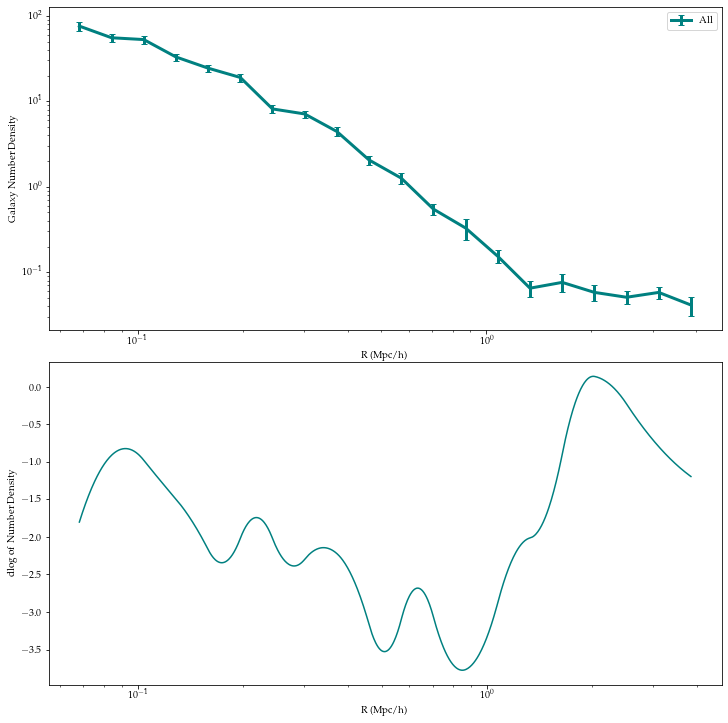

  0%|                                                 | 0/15000 [00:00<?, ?it/s]/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|                                       | 23/15000 [00:00<01:06, 225.78it/s]

Running burn-in...


  0%|                                       | 46/15000 [00:00<01:25, 174.41it/s]/var/folders/dl/x4xpnnsd079f07dshwghwvyw0000gn/T/ipykernel_96927/1527776877.py:35: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
  0%|▏                                       | 21/5000 [00:00<00:23, 209.67it/s]

Running production...


100%|██████████████████████████████████████| 5000/5000 [00:22<00:00, 219.90it/s]


done MCMC
94.89921998977661
Progress: [------------------->] 100%count 0 = 0, count total = 10000


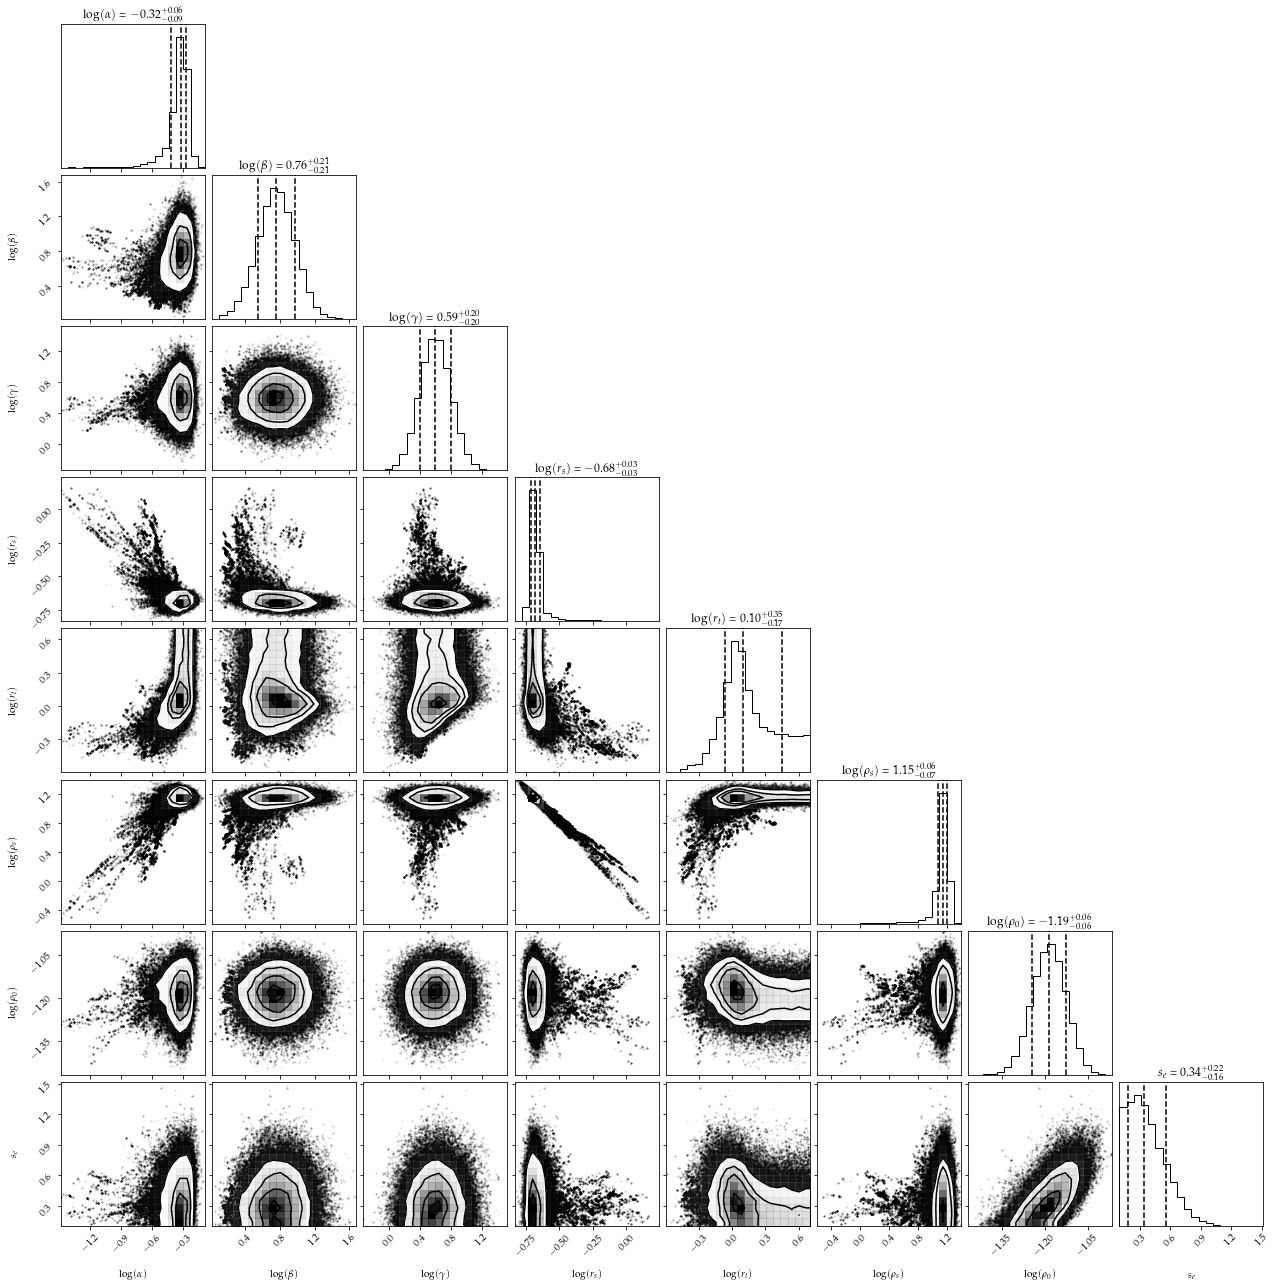

<Figure size 720x576 with 0 Axes>

<Figure size 648x360 with 0 Axes>

0 1.3106430521825987 0.15992342057639017


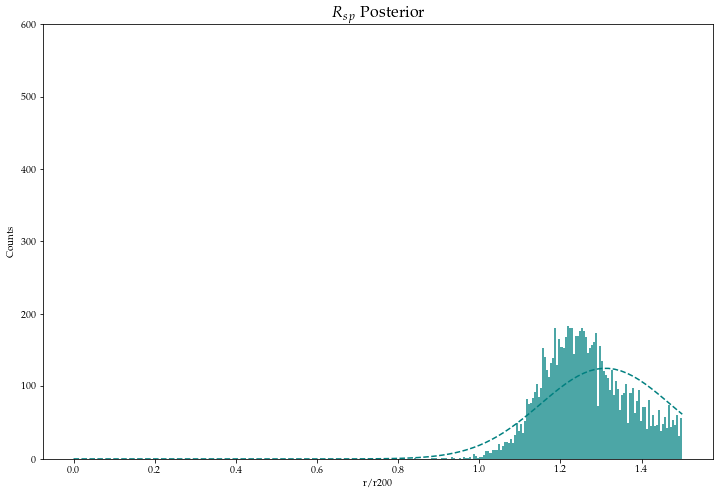

[1.310424647153244] [0.1594493909207986]


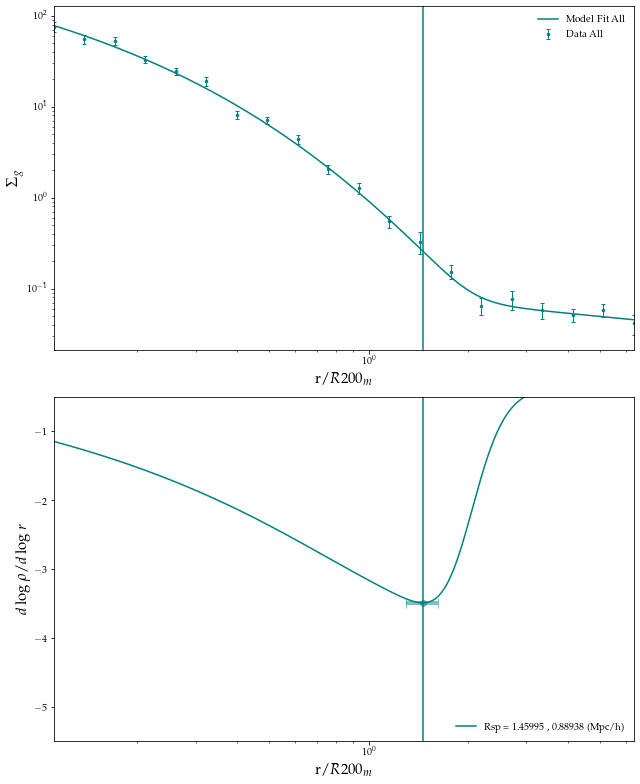

R_avg= 0.6091833790532677
[[0.8893751610494244]] [[1.459946531094796]]
0
Number of halos with mass > 50000000000000.0 and < 70000000000000.0: 136
R_avg: 0.6091833790532677


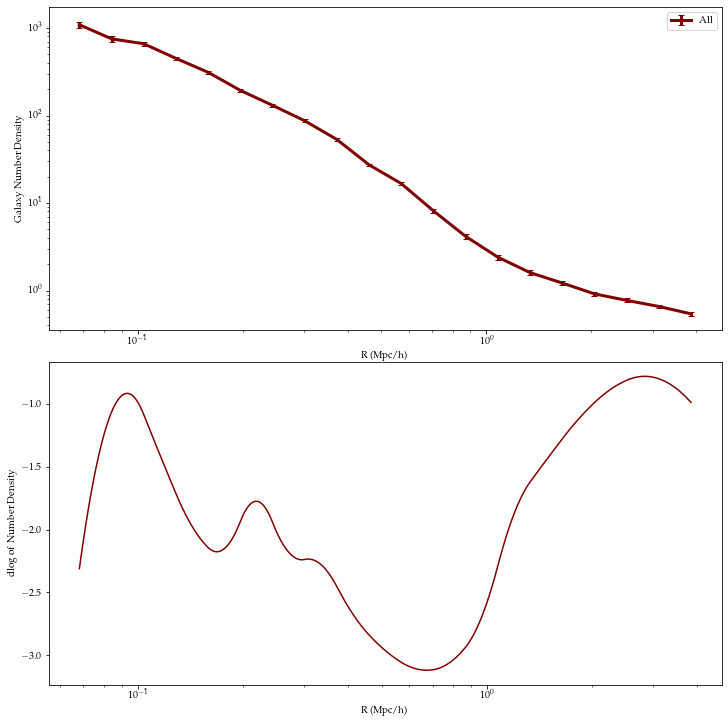

/var/folders/dl/x4xpnnsd079f07dshwghwvyw0000gn/T/ipykernel_96927/1527776877.py:35: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
  0%|                                       | 18/15000 [00:00<01:25, 175.68it/s]

Running burn-in...


  0%|▏                                       | 24/5000 [00:00<00:20, 237.18it/s]

Running production...


100%|██████████████████████████████████████| 5000/5000 [00:23<00:00, 214.65it/s]


done MCMC
98.8053331375122
Progress: [------------------->] 100%count 0 = 0, count total = 10000


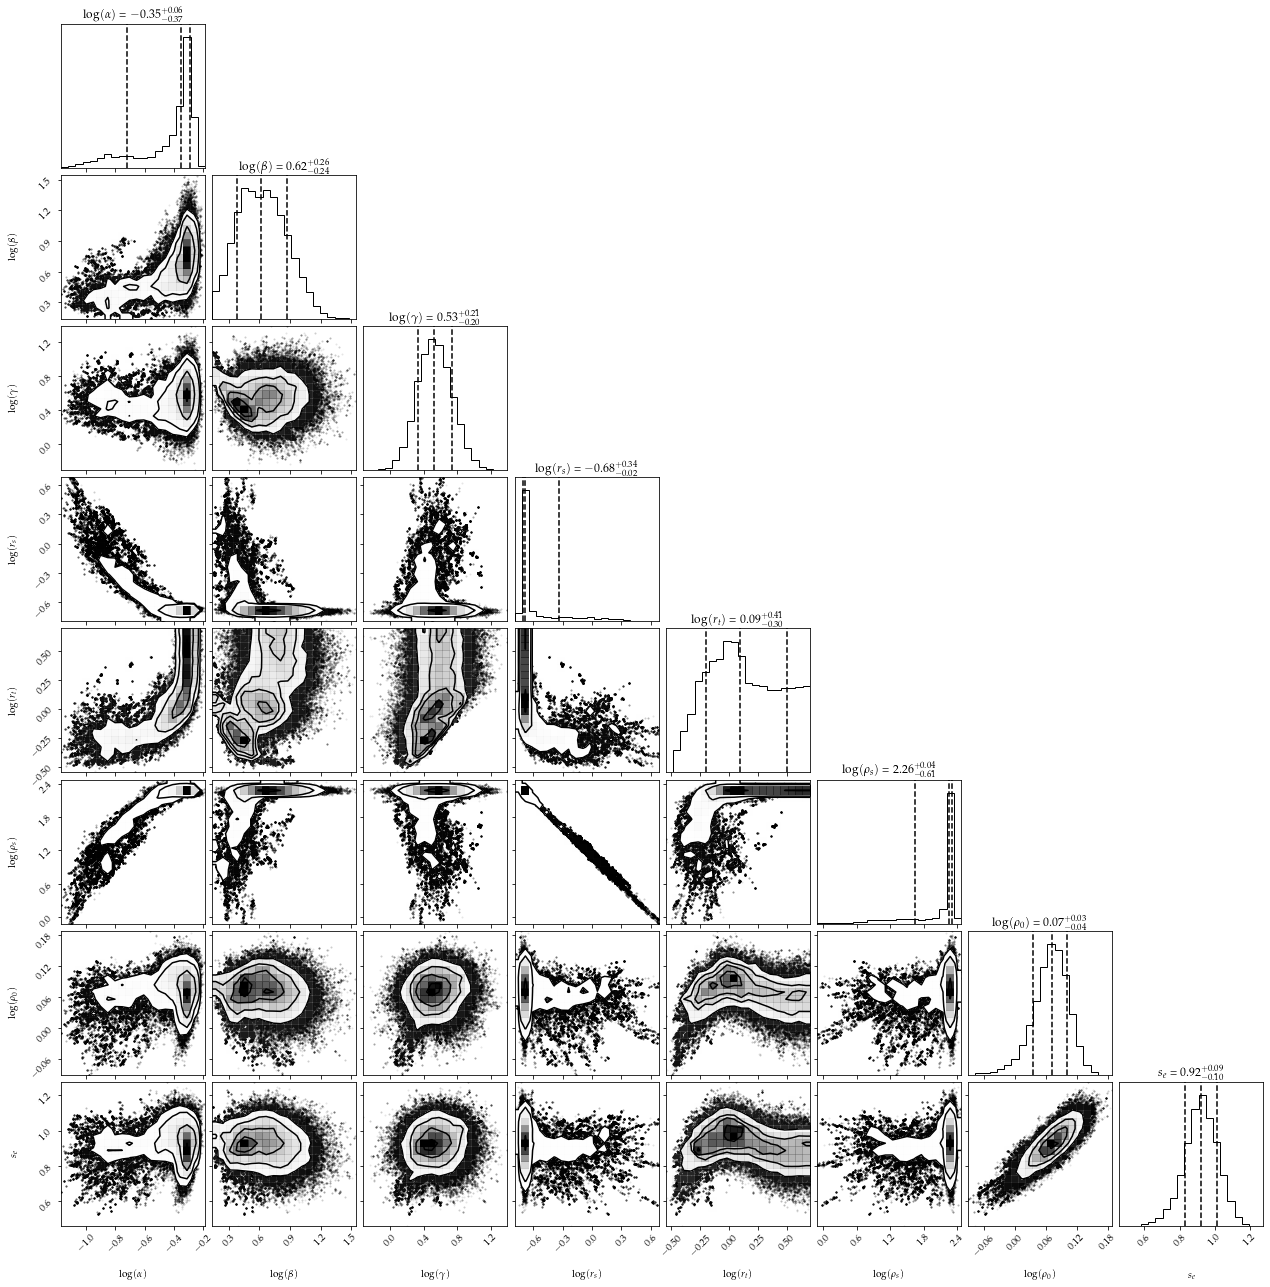

<Figure size 720x576 with 0 Axes>

<Figure size 648x360 with 0 Axes>

0 1.1493835220025663 0.08338118170214544


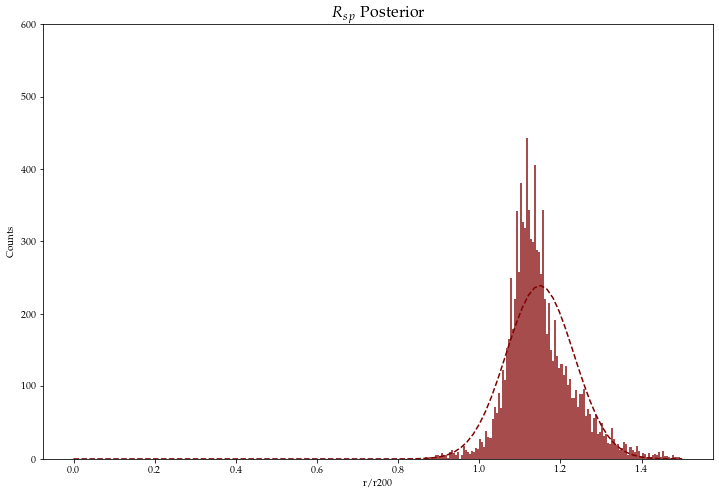

[1.1493835220025663] [0.08338118170214544]


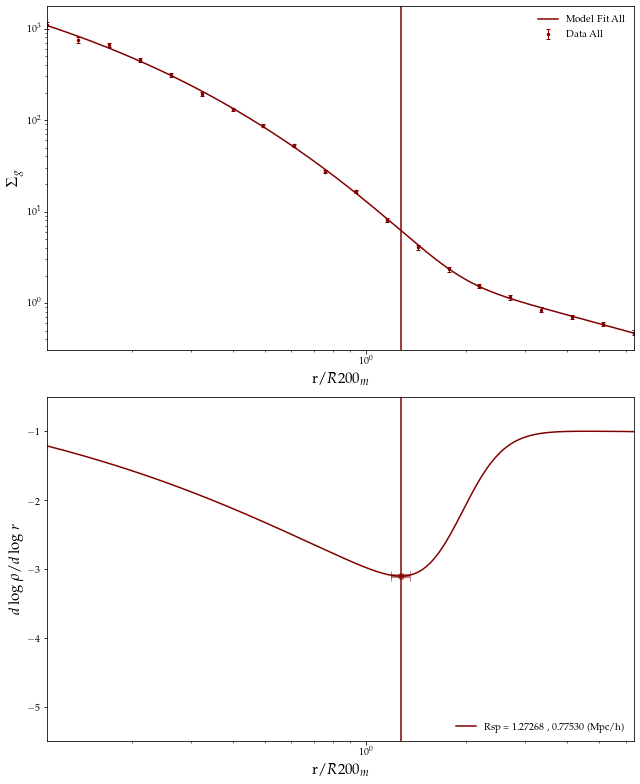

R_avg= 0.6091833790532677
[[0.7752976314605661]] [[1.2726834941975218]]
0
Number of halos with mass > 70000000000000.0 and < 98000000000000.0: 81
R_avg: 0.6897528317417532


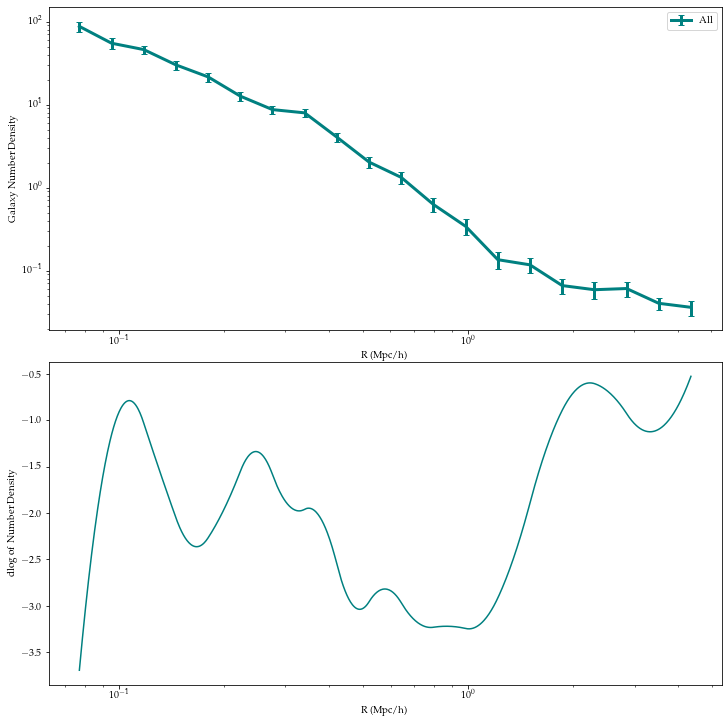

  0%|                                                 | 0/15000 [00:00<?, ?it/s]/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|                                       | 27/15000 [00:00<00:57, 261.74it/s]

Running burn-in...


  0%|▏                                      | 54/15000 [00:00<01:01, 243.77it/s]/var/folders/dl/x4xpnnsd079f07dshwghwvyw0000gn/T/ipykernel_96927/1527776877.py:35: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
  0%|▏                                       | 24/5000 [00:00<00:21, 235.73it/s]

Running production...


100%|██████████████████████████████████████| 5000/5000 [00:22<00:00, 227.01it/s]


done MCMC
94.14246892929077
Progress: [------------------->] 100%count 0 = 0, count total = 10000


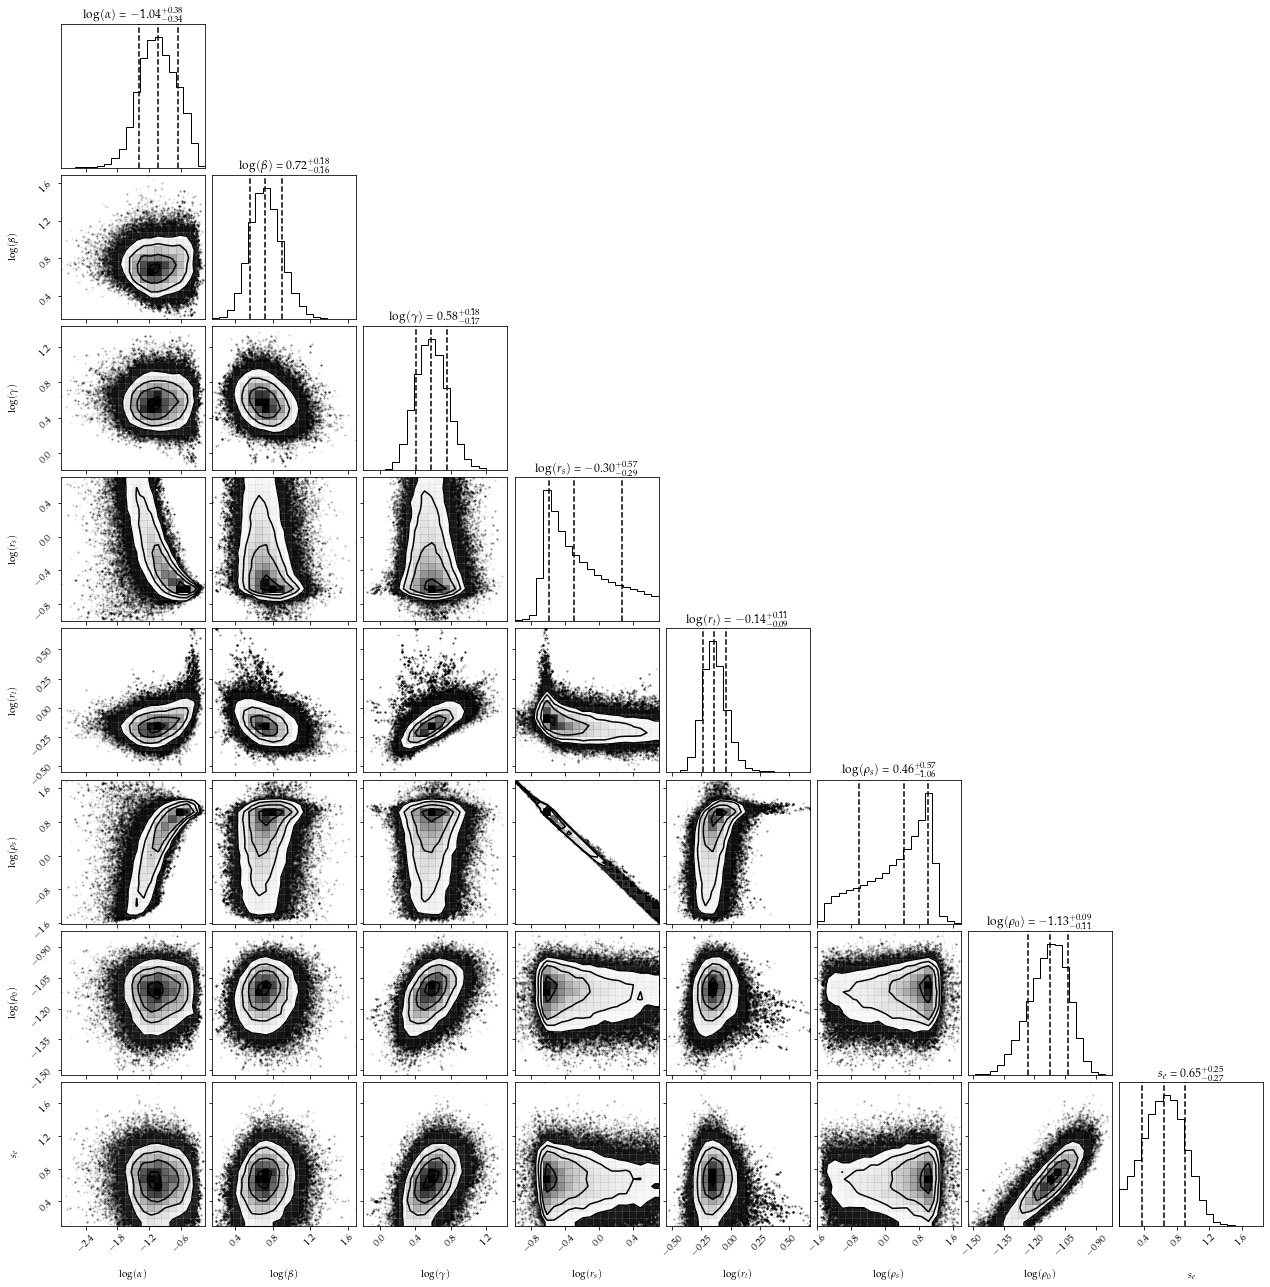

<Figure size 720x576 with 0 Axes>

<Figure size 648x360 with 0 Axes>

0 1.2337238045351897 0.14010673726304246


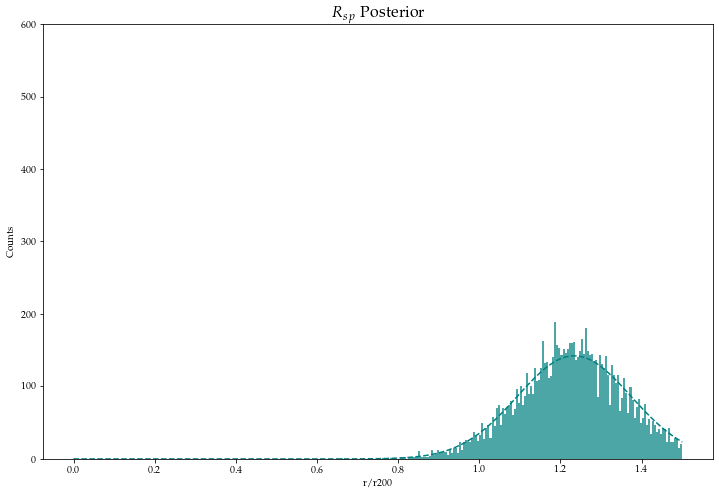

[1.2337238045351897] [0.14010673726304246]


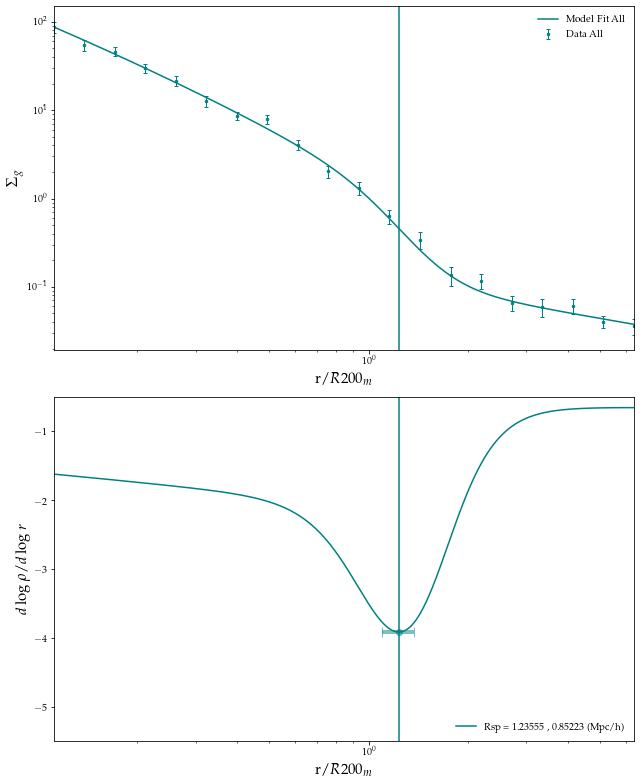

R_avg= 0.6897528317417532
[[0.8522272852109868]] [[1.235554601579461]]
0
Number of halos with mass > 70000000000000.0 and < 98000000000000.0: 81
R_avg: 0.6897528317417532


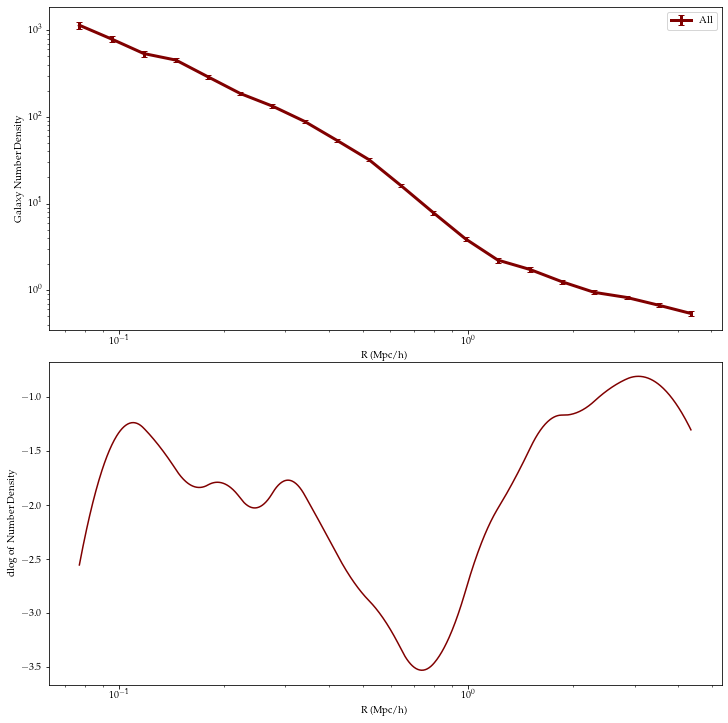

/var/folders/dl/x4xpnnsd079f07dshwghwvyw0000gn/T/ipykernel_96927/1527776877.py:35: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
  0%|                                       | 19/15000 [00:00<01:19, 188.71it/s]

Running burn-in...


  0%|▏                                       | 23/5000 [00:00<00:22, 221.10it/s]

Running production...


100%|██████████████████████████████████████| 5000/5000 [00:23<00:00, 208.57it/s]


done MCMC
100.00364995002747
Progress: [------------------->] 100%count 0 = 0, count total = 10000


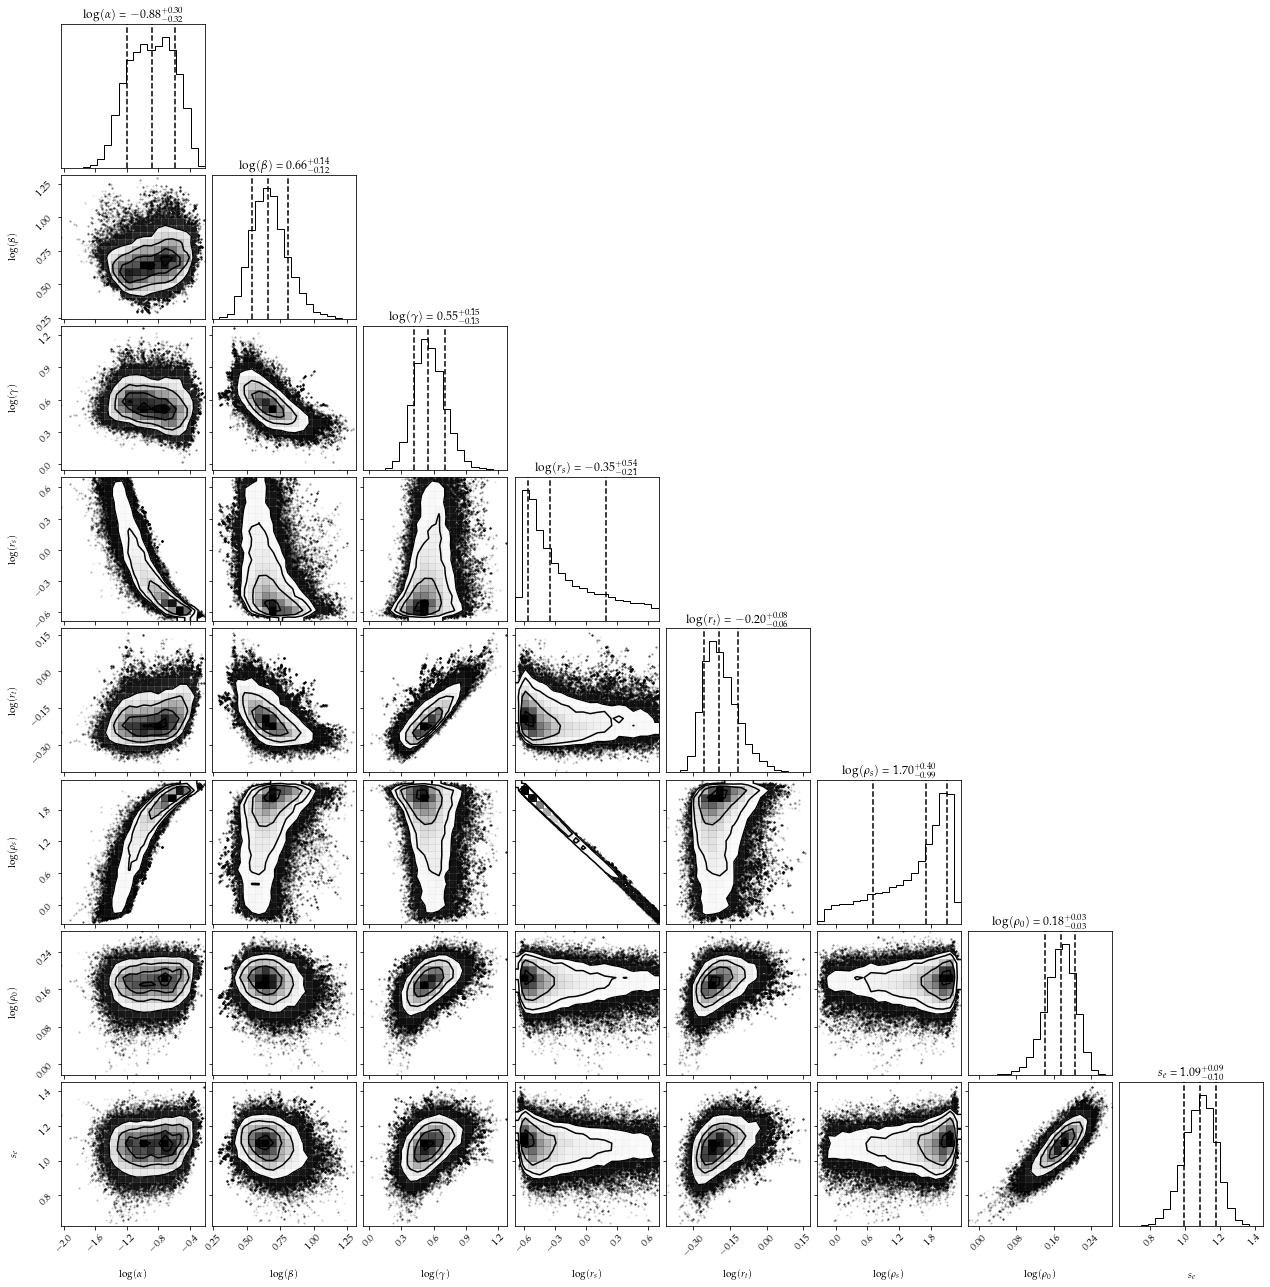

<Figure size 720x576 with 0 Axes>

<Figure size 648x360 with 0 Axes>

0 1.0771948268032363 0.05896883931448699


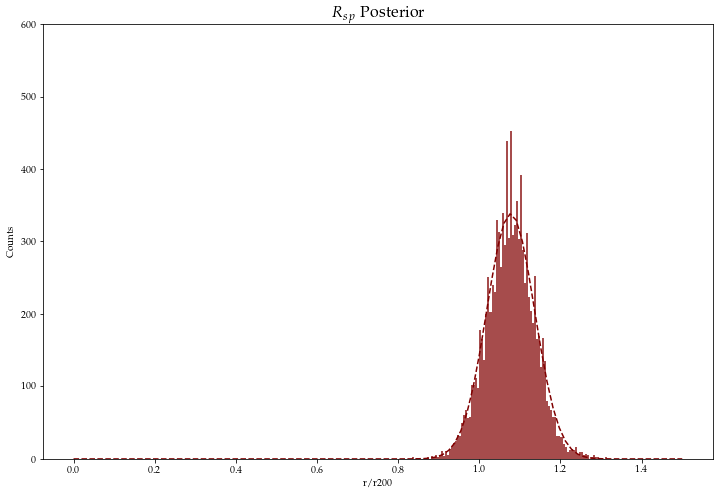

[1.0771948268032363] [0.05896883931448699]


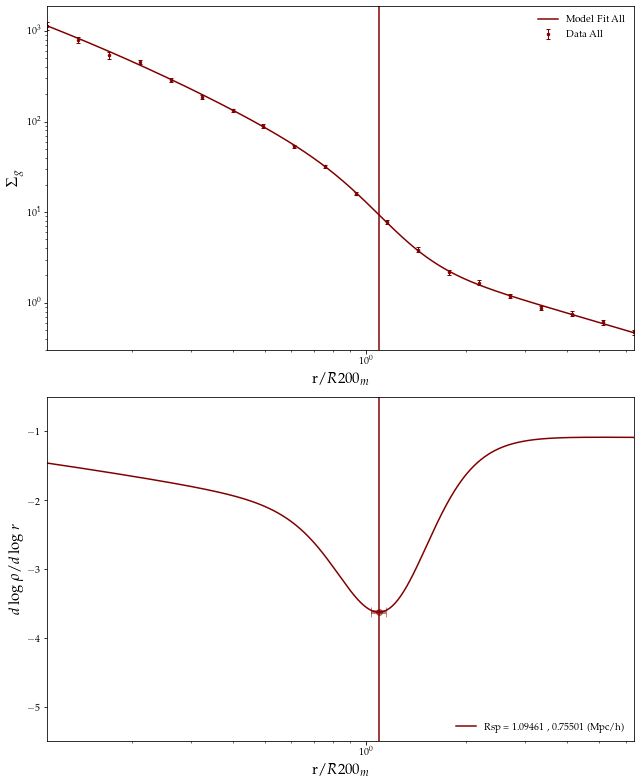

R_avg= 0.6897528317417532
[[0.7550098302566254]] [[1.0946092506066067]]
0
Number of halos with mass > 98000000000000.0 and < 137200000000000.0: 44
R_avg: 0.7603696078069099


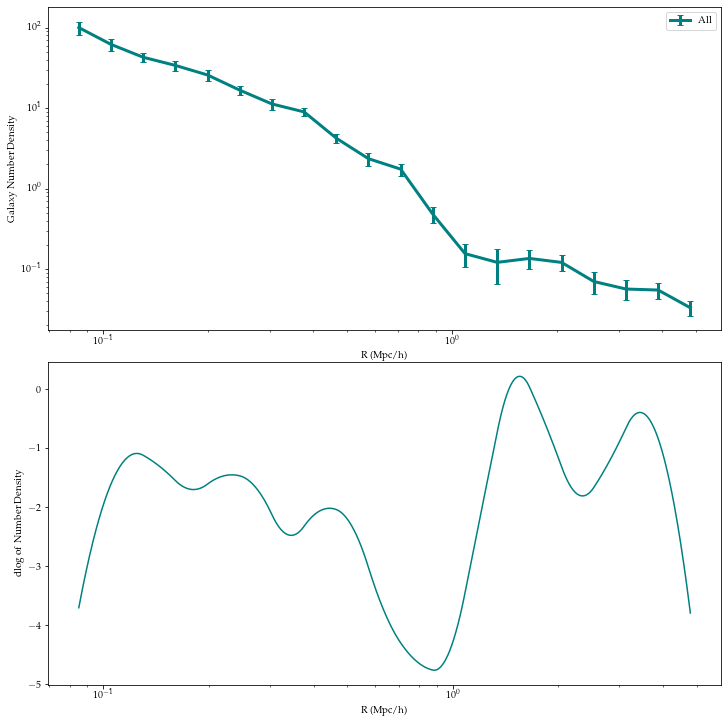

  0%|                                                 | 0/15000 [00:00<?, ?it/s]/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏                                      | 91/15000 [00:00<00:16, 907.39it/s]

Running burn-in...


  2%|▋                                       | 84/5000 [00:00<00:05, 831.12it/s]

Running production...


100%|██████████████████████████████████████| 5000/5000 [00:05<00:00, 895.37it/s]


done MCMC
25.56064224243164
Progress: [------------------->] 100%count 0 = 0, count total = 10000


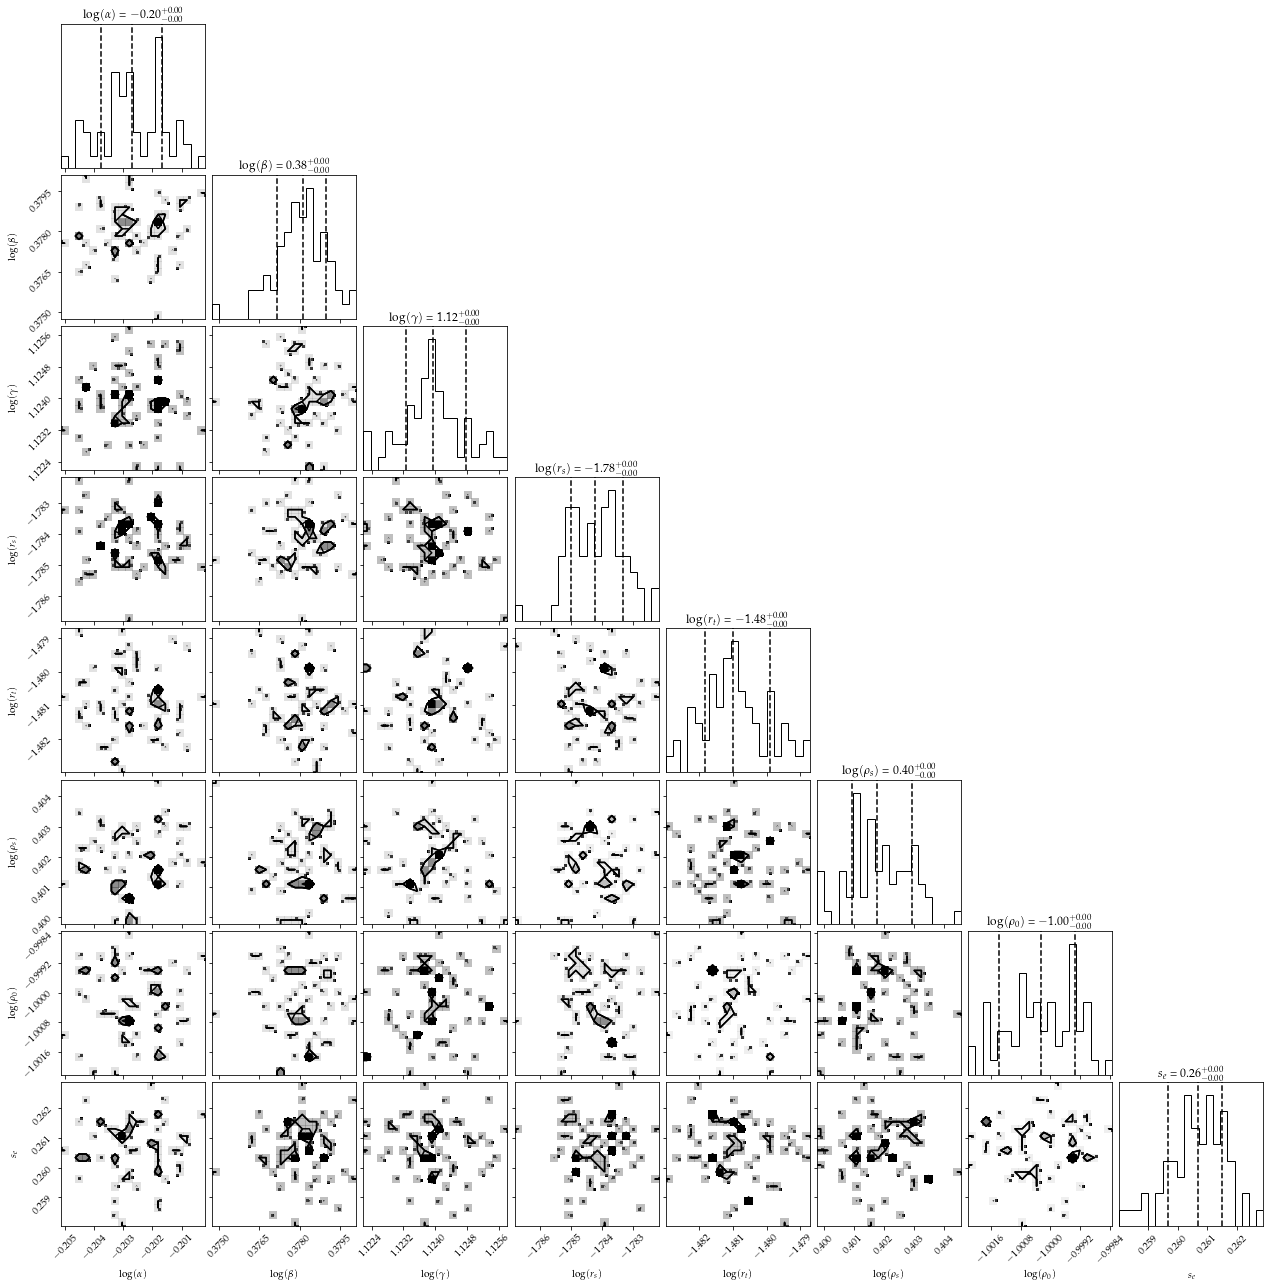

<Figure size 720x576 with 0 Axes>

<Figure size 648x360 with 0 Axes>

/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: Runtime

0 6.330174035458923 0.0


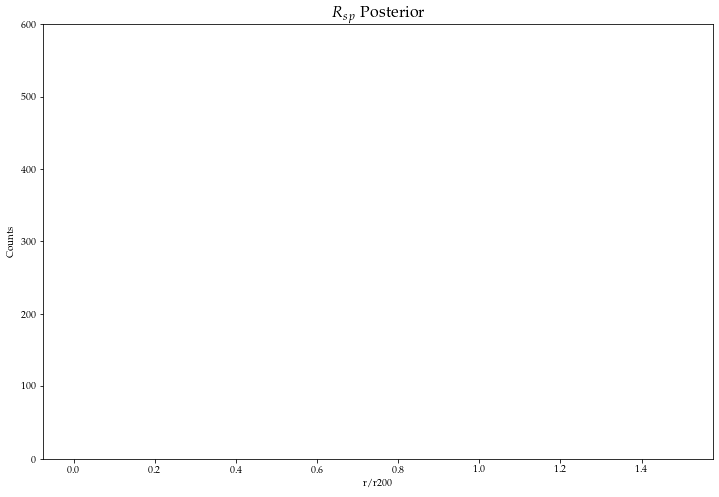

[nan] [nan]


/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


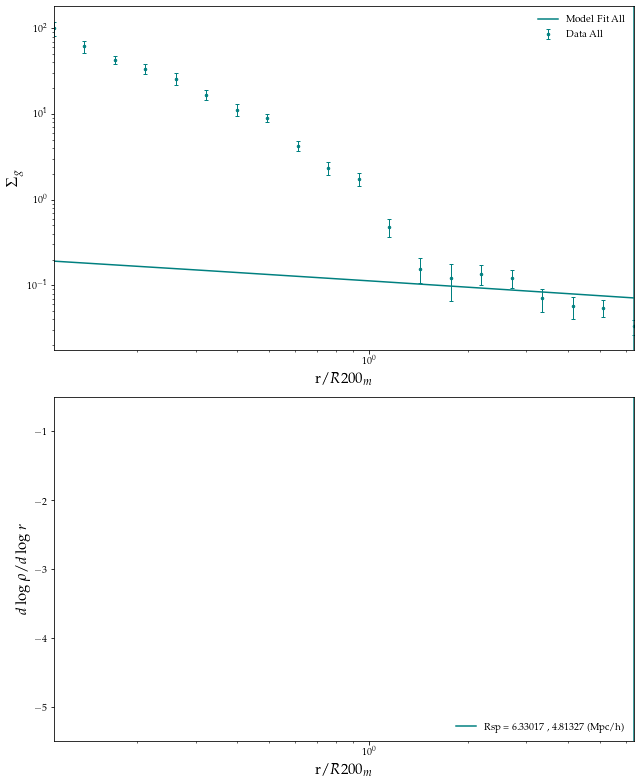

R_avg= 0.7603696078069099
[[4.813271948691385]] [[6.330174035458923]]
0
Number of halos with mass > 98000000000000.0 and < 137200000000000.0: 44
R_avg: 0.7603696078069099


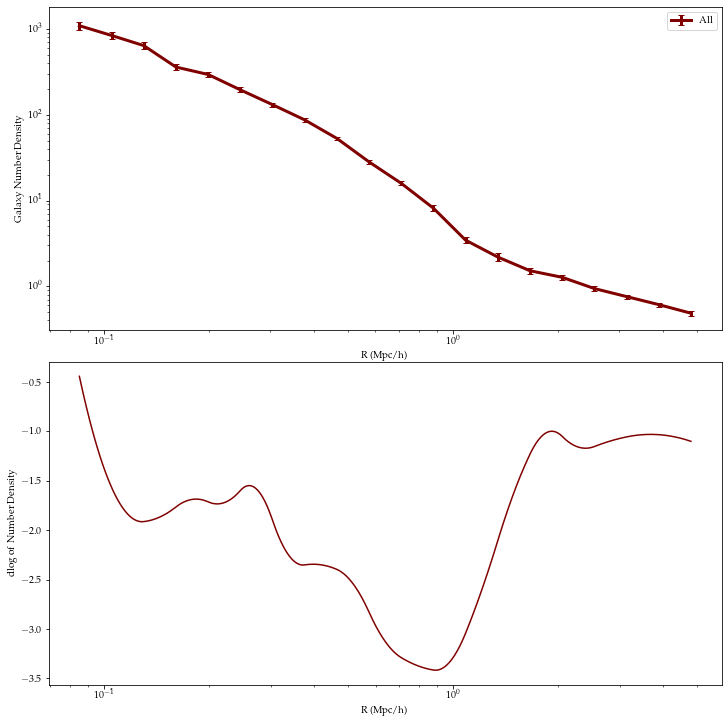

/var/folders/dl/x4xpnnsd079f07dshwghwvyw0000gn/T/ipykernel_96927/1527776877.py:35: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
  0%|                                                 | 0/15000 [00:00<?, ?it/s]/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|                                       | 37/15000 [00:00<00:41, 363.91it/s]

Running burn-in...


  0%|▏                                       | 21/5000 [00:00<00:24, 204.76it/s]

Running production...


100%|██████████████████████████████████████| 5000/5000 [00:23<00:00, 209.86it/s]


done MCMC
97.29685521125793
Progress: [------------------->] 100%count 0 = 0, count total = 10000


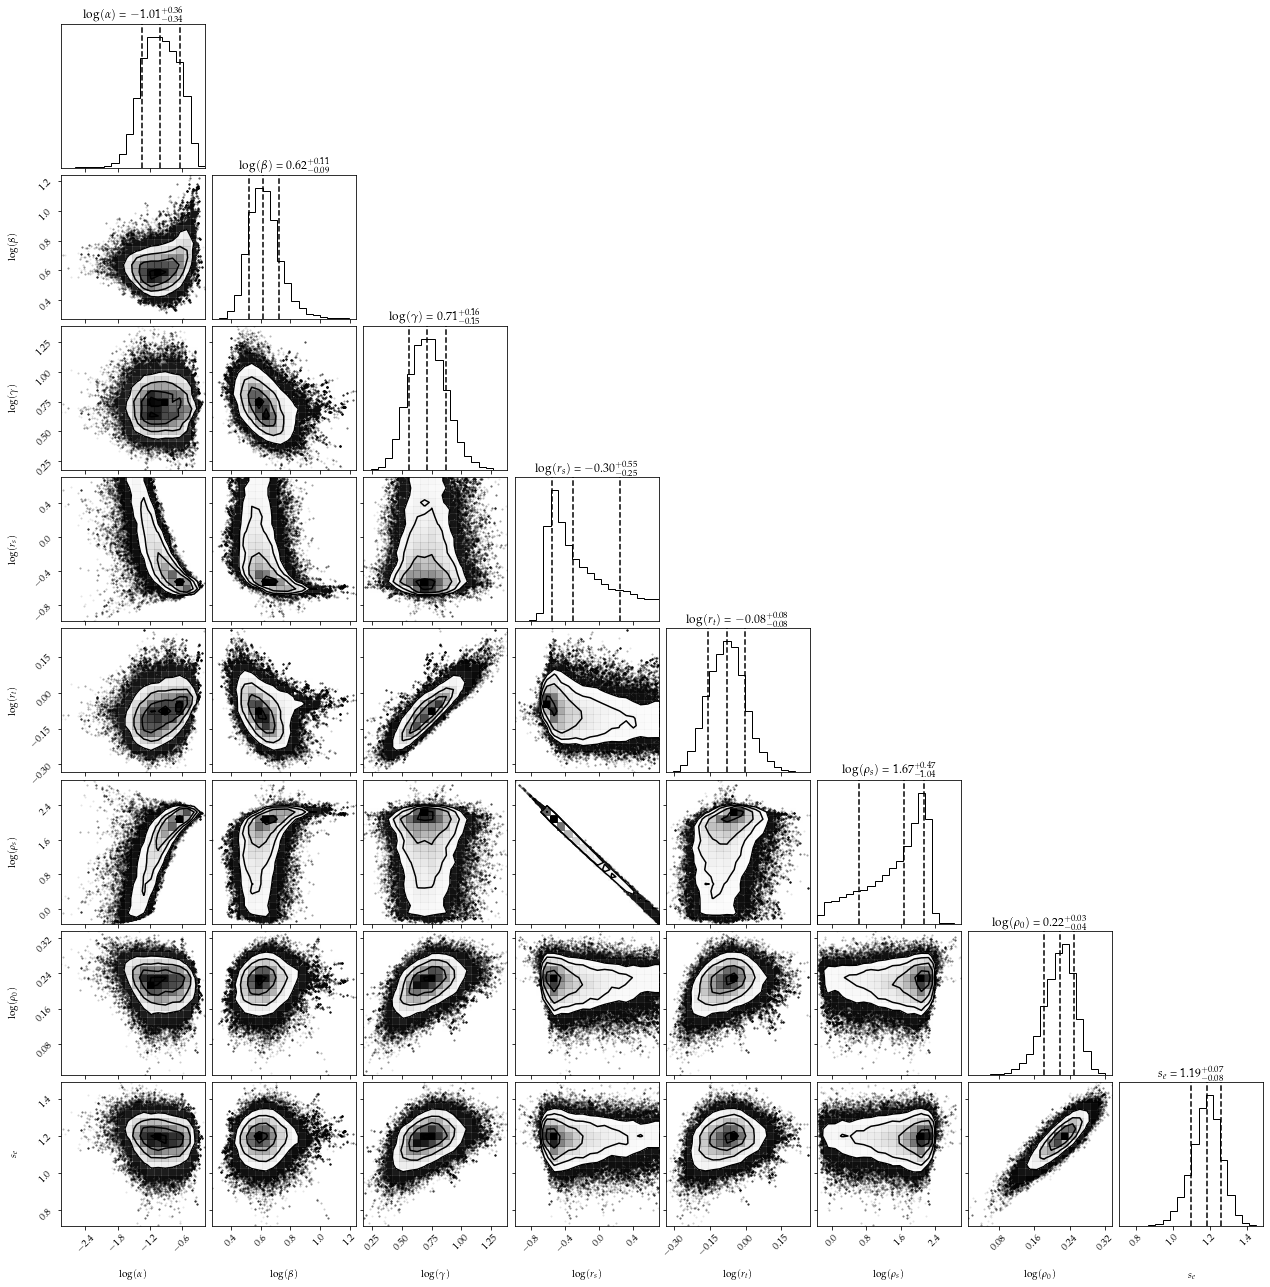

<Figure size 720x576 with 0 Axes>

<Figure size 648x360 with 0 Axes>

0 1.1344974968777197 0.06620750983170448


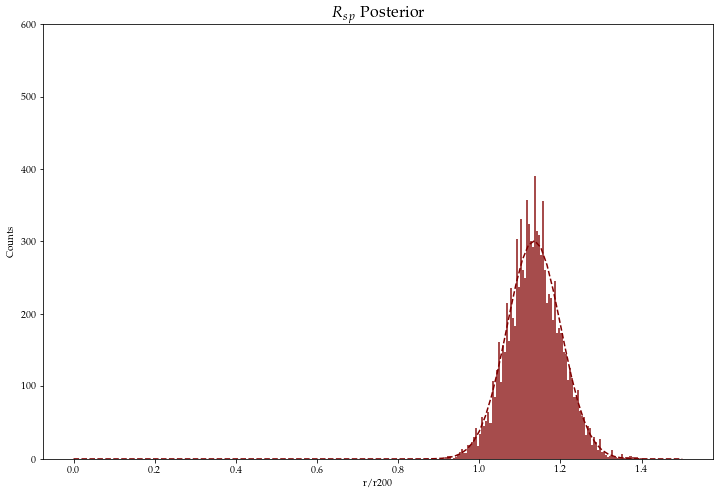

[1.1344974968777197] [0.06620750983170448]


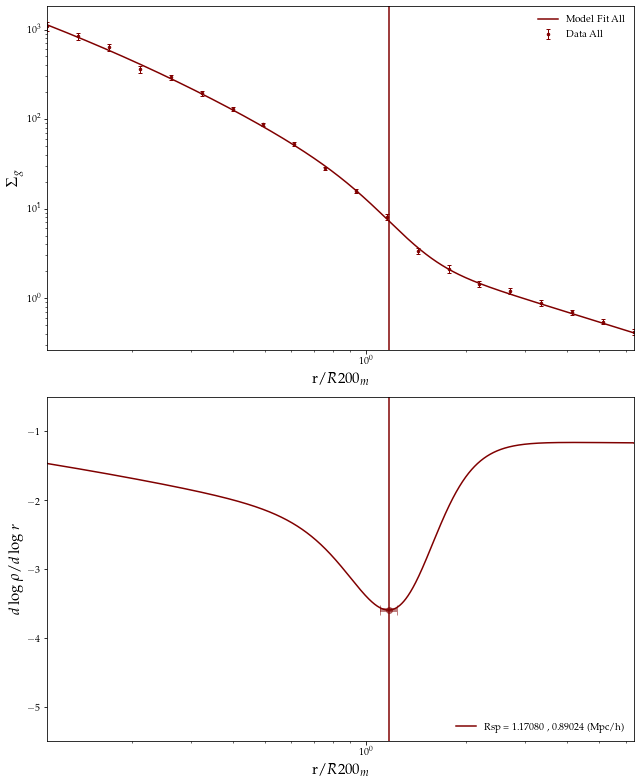

R_avg= 0.7603696078069099
[[0.8902411342319249]] [[1.170800522655812]]


In [32]:
# IMPLEMENTING ABOVE FUNCTIONS FOR 3 MASS BINS WITH 2D AND 3D PROFILES:

import time
t00 = time.time()
m_list = [5*(10**3), 7*(10**3), 9.8*(10**3), 13.72*(10**3)]#[6*(10**3), 8*(10**3), 10.66*(10**3), 14.21*(10**3)]#[5*(10**3), 7*(10**3), 9.8*(10**3), 13.72*(10**3)]
rsp_m2 = []
rsp_r200m_m2 = []
profiles_m2 = []
r_thr_m2 = []
fit_m2 = []
log_deriv_mcmc_m2 = []
rho_g_list_m2 = []
sigs_m2 = []
rsp_samps_m2 = []
alpha_samps_m2 = []
alphas_m2 = []
M200ms_tng_m2 = []


rsp_m3 = []
rsp_r200m_m3 = []
profiles_m3 = []
r_thr_m3 = []
fit_m3 = []
log_deriv_mcmc_m3 = []
rho_g_list_m3 = []
sigs_m3 = []
rsp_samps_m3 = []
alpha_samps_m3 = []
alphas_m3 = []
M200ms_tng_m3 = []

# LOOPING THROUGH MASS BINS AND SAVING RELEVANT PARAMETERS AND QUANTITIES IN LISTS FOR LATER USE:
for n in range(0,len(m_list)-1):
    m_cut = m_list[n]
    m_cut_upper = m_list[n+1]
    rsp, rsp_r200m, profiles, r_thr, fit, log_deriv_mcmc, rho_g_list, sigs, rsp_samp_list_colors, alpha_samp_list_colors, alpha, M200ms_tng = run_splashback([66], m_cut, m_cut_upper, 2)
    rsp_m2.append(rsp)
    rsp_r200m_m2.append(rsp_r200m)
    profiles_m2.append(profiles)
    r_thr_m2.append(r_thr)
    fit_m2.append(fit)
    log_deriv_mcmc_m2.append(log_deriv_mcmc)
    rho_g_list_m2.append(rho_g_list)
    sigs_m2.append(sigs)
    rsp_samps_m2.append(rsp_samp_list_colors)
    alpha_samps_m2.append(alpha_samp_list_colors)
    alphas_m2.append(alpha)
    M200ms_tng_m2.append(M200ms_tng)


    
    rsp, rsp_r200m, profiles, r_thr, fit, log_deriv_mcmc, rho_g_list, sigs, rsp_samp_list_colors, alpha_samp_list_colors, alpha, M200ms_tng = run_splashback([66], m_cut, m_cut_upper, 3)
    rsp_m3.append(rsp)
    rsp_r200m_m3.append(rsp_r200m)
    profiles_m3.append(profiles)
    r_thr_m3.append(r_thr)
    fit_m3.append(fit)
    log_deriv_mcmc_m3.append(log_deriv_mcmc)
    rho_g_list_m3.append(rho_g_list)
    sigs_m3.append(sigs)
    rsp_samps_m3.append(rsp_samp_list_colors)
    alpha_samps_m3.append(alpha_samp_list_colors)
    alphas_m3.append(alpha)
    M200ms_tng_m3.append(M200ms_tng)
    
    

## Plotting 2D and 3D for 3 mass bins

/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


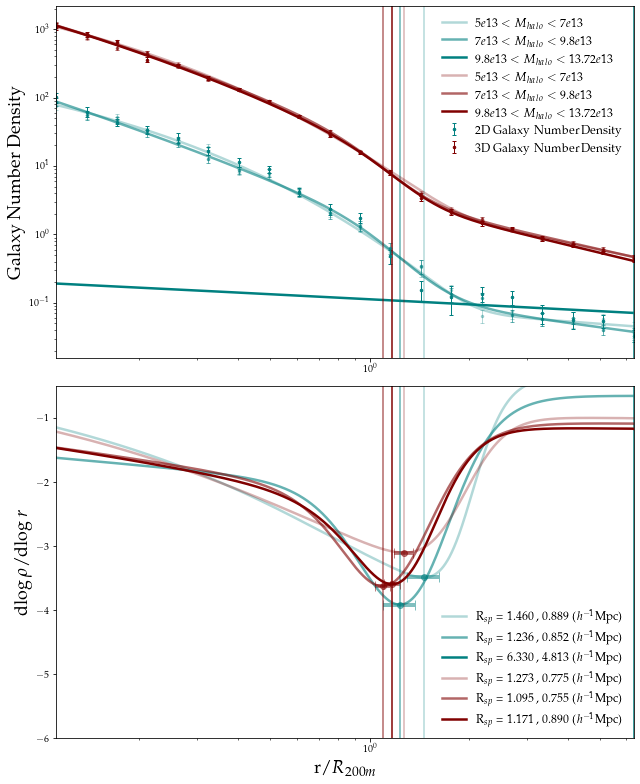

In [33]:
color = [['teal'], ['maroon']]
ls_list_m = [[':'], ['-.'], ['--']]
alpha_list_m = [.3,.6,1]
labels_m = [[r'$5e13 < M_{halo} < 7e13$'], [r'$7e13 < M_{halo} < 9.8e13$'], [r'$9.8e13 < M_{halo} < 13.72e13$']]
labels_D = [[None,None,'2D Galaxy Number Density'], [None,None,'3D Galaxy Number Density']]
plt.figure(figsize=(9,11))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

# LOOPING THROUGH 2D AND 3D
for D in [0,1]:
    
    for m in range(0,len(m_list)-1):
        if D == 0:
            p = profiles_m2[m][0]
            r_thr = r_thr_m2[m]
            fit = fit_m2[m]
            log_deriv_mcmc = log_deriv_mcmc_m2[m]
            r_sp = rsp_m2[m][0][0]
            r_sp_r200 = rsp_r200m_m2[m][0][0]
            rho_g_list = rho_g_list_m2[m]
            sigs = sigs_m2[m]
        elif D == 1:
            p = profiles_m3[m][0]
            r_thr = r_thr_m3[m]
            fit = fit_m3[m]
            log_deriv_mcmc = log_deriv_mcmc_m3[m]
            r_sp = rsp_m3[m][0][0]
            r_sp_r200 = rsp_r200m_m3[m][0][0]
            rho_g_list = rho_g_list_m3[m]
            sigs = sigs_m3[m]
        profiles, averaged_r_tot,Ravg,covs,labels, colors, ls_list = p.Yi_avg_list, p.bin_stack, p.R_avg, p.cov_list, labels_m[m], color[D], ls_list_m[m]
       
        bins = 20
        
        # THIS LOOP IS ARBITRARY AND IS A RELIC OF THE WAY THIS CODE WAS WRITTEN FOR MULTIPLE REDSHIFTS/SNAPSHOTS:
        for i in [0]:
            
            averaged_rho_tot = profiles[i]
           
            Min = min(averaged_r_tot)/Ravg
            Max = max(averaged_r_tot)/Ravg
            ax1.plot(r_thr/Ravg, fit, color=colors[i], linestyle='-',lw = 2.5,alpha = alpha_list_m[m] 
                     , label="%s" %(labels[i]))
            ax1.errorbar(averaged_r_tot/Ravg, averaged_rho_tot - rho_g_list[i], 
                         yerr=np.sqrt(np.diag(covs[i])), 
                         marker = '.', color = colors[i], linestyle = "none",
                         markersize = 5, ecolor = colors[i], elinewidth = 1, capsize=2, 
                         markeredgewidth=1, label = labels_D[D][m], alpha = alpha_list_m[m])

            ax1.axvline(r_sp_r200, linestyle='-', alpha = alpha_list_m[m], color=colors[i])

            ax1.legend(frameon=False, loc="upper right", fontsize = 12)
            #ax1.set_xlabel('r/$R_{200m}$', fontsize=18)#(r"$r$ [h$^{-1}$Mpc]")

            ax1.set_ylabel('Galaxy Number Density', fontsize=18)#(r"$\rho$ [$M_{\odot}h^3$Mpc$^{-3}$]", fontsize=15)
            ax1.set_xscale("log")
            ax1.set_yscale("log")
            ax1.set_xlim(Min,Max)#(0.08, 3) #2


            ax2.plot(r_thr/Ravg, log_deriv_mcmc, color=colors[i], label=r'R$_{sp}$ = %s , %s ($h^{-1}$Mpc)' %("{:.3f}".format(r_sp_r200),"{:.3f}".format(r_sp)), linestyle='-', lw = 2.5,alpha = alpha_list_m[m]) 

            ax2.axvline(r_sp_r200, linestyle='-', alpha = alpha_list_m[m], color=colors[i])
            ax2.errorbar(r_sp_r200,np.min(log_deriv_mcmc),xerr = sigs[i],color = colors[i], fmt = 'o', elinewidth = 4,capsize = 5, alpha = .5)

            ax2.set_xscale("log")
            ax2.set_xlabel('r/$R_{200m}$', fontsize=18)#(r"$r$ [h$^{-1}$Mpc]")

            ax2.set_ylabel(r"d$\log \rho / $d$\log r$", fontsize=18)
            ax2.set_xlim(Min,Max)#(0.08, 3) #2
            ax2.set_ylim(-6, -0.5)
            ax2.legend(frameon=False, loc="lower right", fontsize = 12)

plt.tight_layout()

plt.savefig('/Users/TaraD/Desktop/2d3dProfiles.pdf')

plt.show()

[[[1.459946531094796]], [[1.235554601579461]], [[6.330174035458923]]]


/Users/TaraD/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


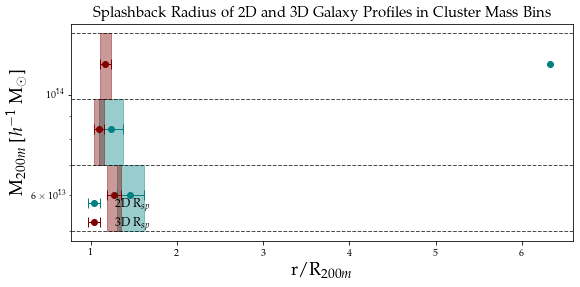

[[[1.459946531094796]], [[1.235554601579461]], [[6.330174035458923]]]


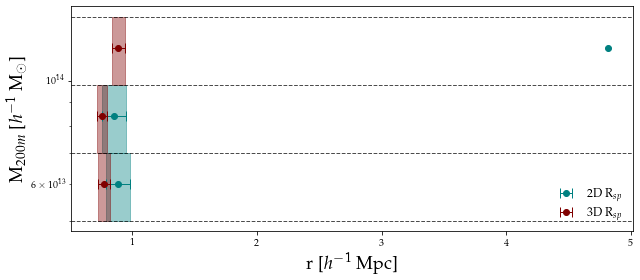

In [34]:
# PLOTTING SPLASHBACK VALUES AND ERROR FOR 2D AND 3D
plt.figure(figsize = (9,4))

labels_D_Rsp = [[None,None,r'2D R$_{sp}$'], [None,None,r'3D R$_{sp}$']]

print(rsp_r200m_m2)
size_arr = np.array(m_list[1:])-np.array(m_list[:-1])
for m in range(0,len(m_list)-1):
    plt.errorbar(np.array(rsp_r200m_m2)[m,0,0], ((np.array(m_list)[m+1]*1e10 + np.array(m_list)[m]*1e10) / 2), xerr = np.array(sigs_m2)[m,0,0], elinewidth = 1,fmt = 'o', capsize = 5, color = color[0][0], ls = 'None', label = labels_D_Rsp[0][m])
    plt.errorbar(np.array(rsp_r200m_m3)[m,0,0], ((np.array(m_list)[m+1]*1e10 + np.array(m_list)[m]*1e10) / 2), xerr = np.array(sigs_m3)[m,0,0], elinewidth = 1,fmt = 'o', capsize = 5, color = color[1][0], ls = 'None', label = labels_D_Rsp[1][m])
    plt.yscale('log')
    plt.fill_between([np.array(rsp_r200m_m2)[m,0,0]-np.array(sigs_m2)[m,0,0], np.array(rsp_r200m_m2)[m,0,0]+np.array(sigs_m2)[m,0,0]], [((np.array(m_list)[m+1]*1e10)),((np.array(m_list)[m+1]*1e10))], [((np.array(m_list)[m]*1e10)),((np.array(m_list)[m]*1e10))], color = color[0][0], alpha = .4)
    plt.fill_between([np.array(rsp_r200m_m3)[m,0,0]-np.array(sigs_m3)[m,0,0], np.array(rsp_r200m_m3)[m,0,0]+np.array(sigs_m3)[m,0,0]], [((np.array(m_list)[m+1]*1e10)),((np.array(m_list)[m+1]*1e10))], [((np.array(m_list)[m]*1e10)),((np.array(m_list)[m]*1e10))], color = color[1][0], alpha = .4)
    plt.legend(frameon=False, loc="lower left", fontsize = 12)
    plt.ylabel(r'M$_{200m}$ [$h^{-1}$ M$_{\odot}$]', fontsize = 18)
    plt.xlabel(r'r/R$_{200m}$', fontsize = 18)
    plt.title('Splashback Radius of 2D and 3D Galaxy Profiles in Cluster Mass Bins', fontsize = 15)

    plt.axhline(m_list[m]*1e10, color = 'k', ls = '--', lw = 1, alpha = .7)

plt.axhline(m_list[3]*1e10, color = 'k', ls = '--', lw = 1, alpha = .7)

plt.show()

# PLOTTING SAME FIGURE BUT IN UNITS OF MPC WHICH WILL BE USED IN THE SUBSEQUENT METHODS:
plt.figure(figsize = (9,4))

labels_D_Rsp = [[None,None,r'2D R$_{sp}$'], [None,None,r'3D R$_{sp}$']]

print(rsp_r200m_m2)
size_arr = np.array(m_list[1:])-np.array(m_list[:-1])
for m in range(0,len(m_list)-1):
    sig_m2 = np.array(sigs_m2)[m,0,0]
    sig_m2_mpc = sig_m2*(profiles_m2[m][0]).R_avg
    
    sig_m3 = np.array(sigs_m3)[m,0,0]
    sig_m3_mpc = sig_m3*(profiles_m3[m][0]).R_avg
    
    plt.errorbar(np.array(rsp_m2)[m,0,0], ((np.array(m_list)[m+1]*1e10 + np.array(m_list)[m]*1e10) / 2), xerr = sig_m2_mpc, elinewidth = 1,fmt = 'o', capsize = 5, color = color[0][0], ls = 'None', label = labels_D_Rsp[0][m])
    plt.errorbar(np.array(rsp_m3)[m,0,0], ((np.array(m_list)[m+1]*1e10 + np.array(m_list)[m]*1e10) / 2), xerr = sig_m3_mpc, elinewidth = 1,fmt = 'o', capsize = 5, color = color[1][0], ls = 'None', label = labels_D_Rsp[1][m])
    plt.yscale('log')
    
    plt.fill_between([np.array(rsp_m2)[m,0,0]-sig_m2_mpc, np.array(rsp_m2)[m,0,0]+sig_m2_mpc], [((np.array(m_list)[m+1]*1e10)),((np.array(m_list)[m+1]*1e10))], [((np.array(m_list)[m]*1e10)),((np.array(m_list)[m]*1e10))], color = color[0][0], alpha = .4)
    plt.fill_between([np.array(rsp_m3)[m,0,0]-sig_m3_mpc, np.array(rsp_m3)[m,0,0]+sig_m3_mpc], [((np.array(m_list)[m+1]*1e10)),((np.array(m_list)[m+1]*1e10))], [((np.array(m_list)[m]*1e10)),((np.array(m_list)[m]*1e10))], color = color[1][0], alpha = .4)
    plt.legend(frameon=False, loc="lower right", fontsize = 12)
    plt.ylabel(r'M$_{200m}$ [$h^{-1}$ M$_{\odot}$]', fontsize = 18)
    plt.xlabel(r'r [$h^{-1}$ Mpc]', fontsize = 18)
    #plt.title('Splashback Radius of 2D and 3D Galaxy Profiles in Cluster Mass Bins', fontsize = 15)

    plt.axhline(m_list[m]*1e10, color = 'k', ls = '--', lw = 1, alpha = .7)

plt.axhline(m_list[3]*1e10, color = 'k', ls = '--', lw = 1, alpha = .7)
plt.tight_layout()

plt.savefig('/Users/TaraD/Desktop/2d3dSplashback.pdf')

plt.show()


## Rsp to Msp Methods:

In [23]:
import scipy.integrate as sp
from colossus.cosmology import cosmology
from colossus.halo import profile_einasto, splashback, mass_so, concentration
from colossus.lss import peaks
cosmology.setCosmology('planck15')


# FUNCTION FOR EINASTO PROFILE GIVEN PARAMETERS
def Einasto(r, rho_s, r_s, alpha):
    exp_arg = -2/alpha*(((r/r_s)**alpha)-1)
    rho_EIN = rho_s*np.exp(exp_arg)
    return rho_EIN

# FUNCTION TO INTEGRATE PROFILE TO GET MSP GIVEN EINASTO PROFILE:
def Msp_int(Rsp,rho_s, r_s, alpha):
    def Integrand(r,rho_s, r_s, alpha):
        return Einasto(r, rho_s, r_s, alpha)*4*np.pi*(r**2)
    Msp = sp.quad(Integrand, 0, Rsp, args = (rho_s, r_s, alpha))
    return Msp[0]

# FUNCTION TO GET PEAK HEIGHT FROM ALPHA USING GAO ET AL RELATION:
def nu_func(alpha):
    # alpha = 0.155 + .0095v^2 # THIS IS THE RELATION
    v = np.sqrt((alpha - 0.155)/.0095)
    return v

# FUNCTION TO GET R200M FROM SPLASHBACK RADIUS AND PEAK HEIGHT USING MORE ET AL 2015: 
def R200m_func(Rsp, nu, z):
    Rsp_over_R200m = splashback.modelMore15RspR200m(nu200m=nu, z=z, Gamma=None, statistic='mean')
    R200m = Rsp/Rsp_over_R200m
    return R200m # in kpc/h if Rsp is in kpc/h

# FUNCTION FOR METHOD 1 OF GETTING SPLASHBACK MASS:
def Method1(Rsp, alpha, z): #Rsp in Mpc/h?
    # 1
    nu = nu_func(alpha)
    #print('nu = ',nu)
    # 2
    R200m = R200m_func(Rsp, nu, z) 
    # 3
    M200m = mass_so.R_to_M(R200m, z, mdef = '200m')
    # 4
    #c = 10**(-.125*np.log10(m) + 2.372) #add in h term? # Gao et al 2008 for c200 # could use colossus but its 200c?
    c,mask = concentration.modelBhattacharya13(M200m, z, mdef = '200m')
    # 5
    p_einasto = profile_einasto.EinastoProfile(M = M200m, c = c, z = z, mdef = '200m')
    rhos = p_einasto.par['rhos'] # in Msun*h^2/kpc^3
    rs = p_einasto.par['rs'] # in kpc
    alpha_new = p_einasto.par['alpha']
    # 6
    Msp = Msp_int(Rsp, rhos, rs, alpha)
    return Msp #np.format_float_scientific(Msp)
    
# FUNCTION FOR METHOD 2 OF GETTING SPLASHBACK MASS:
def Method2(Rsp, alpha, z): #Rsp in Mpc/h?
    # 1
    nu = nu_func(alpha)
    # 2
    R200m = R200m_func(Rsp, nu, z) 
    # 3
    M200m = mass_so.R_to_M(R200m, z, mdef = '200m')
    # 4
    Msp_over_M200m = splashback.modelMore15MspM200m(nu200m=nu, z=z, Gamma=None, statistic='mean')
    #Msp_over_M200m = splashback.modelDiemer20MspM200m(nu200m=nu, z=z, rspdef='mean')
    
    Msp = Msp_over_M200m*M200m
    
    return Msp

# FUNCTION FOR METHOD 3 OF GETTING SPLASHBACK MASS:
def Method3(Rsp, alpha, z): #Rsp in Mpc/h?
    # 1
    nu = nu_func(alpha)
    # 2
    M200m = peaks.massFromPeakHeight(nu, z) # THIS IS NOT USEFUL SO METHODS 3 AND 4 NOT USED IN THESIS
    # 3
    #c = 10**(-.125*np.log10(m) + 2.372) #add in h term? # Gao et al 2008 for c200 # could use colossus but its 200c?
    c,mask = concentration.modelBhattacharya13(M200m, z, mdef = '200m')
    #print('c = ',c) 
    # 4
    p_einasto = profile_einasto.EinastoProfile(M = M200m, c = c, z = z, mdef = '200m')
    rhos = p_einasto.par['rhos'] # in Msun*h^2/kpc^3
    rs = p_einasto.par['rs'] # in kpc
    alpha_new = p_einasto.par['alpha']
    # 5
    Msp = Msp_int(Rsp, rhos, rs, alpha)
    return Msp
    
# FUNCTION FOR METHOD 4 OF GETTING SPLASHBACK MASS:
def Method4(Rsp, alpha, z): #Rsp in Mpc/h?
    # 1
    nu = nu_func(alpha)
    # 2
    M200m = peaks.massFromPeakHeight(nu, z)
    # 4
    Msp_over_M200m = splashback.modelMore15MspM200m(nu200m=nu, z=z, statistic='mean')
    Msp = Msp_over_M200m*M200m
    
    return Msp



print(rsp_m2)
print('Msp1 = ',Method1(Rsp = .77*1000, alpha = 10**-.8, z = 0.52))
print('Msp1 = ',Method1(Rsp = .82*1000, alpha = 10**-.8, z = 0.52))
print('Msp1 = ',Method1(Rsp = .89*1000, alpha = 10**.65, z = 0.52))


[[[0.9087336498564548]], [[0.8329507907143578]], [[0.8677659715073954]]]
Msp1 =  57866545224981.75
Msp1 =  70172149326219.69
Msp1 =  57428627310685.94


/var/folders/dl/x4xpnnsd079f07dshwghwvyw0000gn/T/ipykernel_96927/2794577044.py:14: RuntimeWarning: overflow encountered in double_scalars
  exp_arg = -2/alpha*(((r/r_s)**alpha)-1)
/var/folders/dl/x4xpnnsd079f07dshwghwvyw0000gn/T/ipykernel_96927/2794577044.py:27: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt((alpha - 0.155)/.0095)
/var/folders/dl/x4xpnnsd079f07dshwghwvyw0000gn/T/ipykernel_96927/2794577044.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Msp = sp.quad(Integrand, 0, Rsp, args = (rho_s, r_s, alpha))


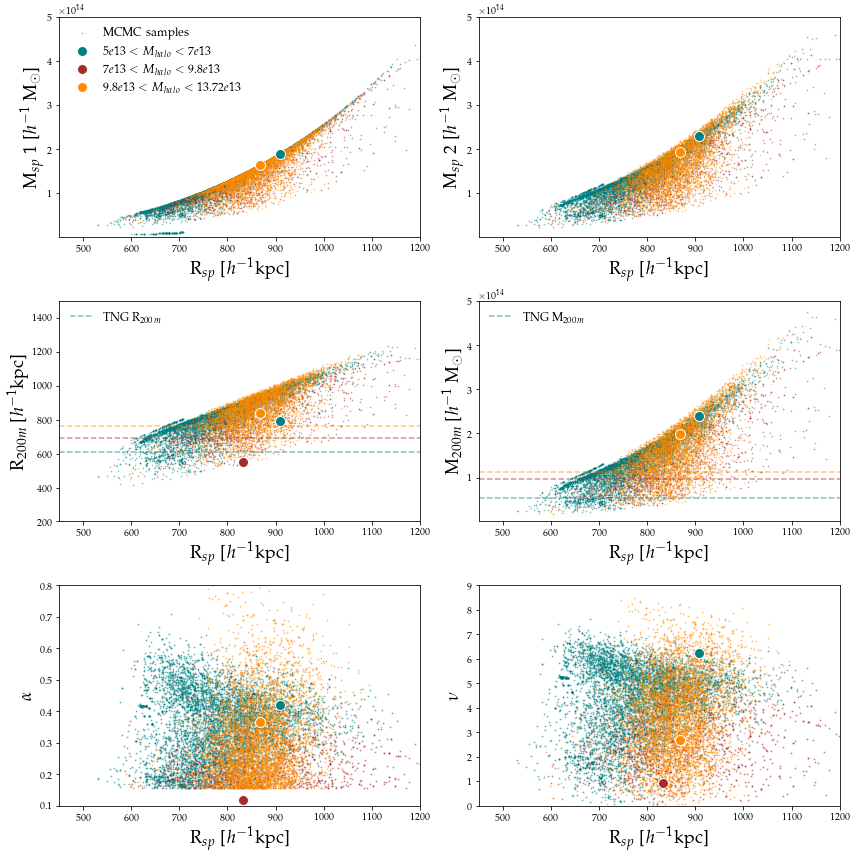

In [24]:
# PLOTTING SPLASHBACK MASSES, M200MS, R200MS, AND OTHER PARAMETERS/QUANTITIES RELEVANT TO SPLASHBACK MASSES FOR CLUSTER MASS BINS ALONG WITH MCMC DISTRIBUTIONS:
import matplotlib.tri as tri

colors = ['teal', 'brown', 'darkorange']
labels_m = [[r'$5e13 < M_{halo} < 7e13$'], [r'$7e13 < M_{halo} < 9.8e13$'], [r'$9.8e13 < M_{halo} < 13.72e13$']]
labels_samps = ['MCMC samples', None, None]
a = [.4,.4,.4]
z = 0.52
fig, ax = plt.subplots(3,2,figsize = (12,12))

for m in [0,1,2]:

    ax1 = ax[0,0]
    ax6 = ax[0,1]
    ax2 = ax[1,0]
    ax3 = ax[1,1]
    ax4 = ax[2,0]
    ax5 = ax[2,1]
    
    Rsp_samps = 1000*rsp_samps_m2[m][0][0]
    Rsp = rsp_m2[m][0][0]*1000
   
    alpha_samps = alpha_samps_m2[m][0][0]


    Rsp_samps_new = []
    alpha_samps_new = []
    Msp_samps = []
    nu_samps = []
    R200m_samps = []
    M200m_samps = []
    Msp_samps2 = []
    
    Msp = Method1(Rsp, alphas_m2[m][0][0], z)
    Msp_2 = Method2(Rsp, alphas_m2[m][0][0], z)
    #Msp_3 = Method3(rsp_m2[m][0][0]*1000, alphas_m2[m][0][0], z)
    #Msp_4 = Method4(rsp_m2[m][0][0]*1000, alphas_m2[m][0][0], z)

    nu = nu_func(alphas_m2[m][0][0])
    R200m = R200m_func(Rsp, nu, z)
    M200m = mass_so.R_to_M(R200m, z, mdef = '200m')
    R200m_tng = Rsp/rsp_r200m_m2[m][0][0]
    M200ms_tng = M200ms_tng_m2[m][0][0]
    M200m_tng = np.mean(np.array(M200ms_tng)*1e10)
    M200m_alt = peaks.massFromPeakHeight(nu, z)
 
    for i in range(len(Rsp_samps)):
        if alpha_samps[i] > .155:
            Rsp_samps_new.append(Rsp_samps[i])
            alpha_samps_new.append(alpha_samps[i])
            Msp_samps.append(Method1(Rsp_samps[i], alpha_samps[i], z))
            Msp_samps2.append(Method2(Rsp_samps[i], alpha_samps[i], z))
            nu = nu_func(alpha_samps[i])
            nu_samps.append(nu)
            R200m = R200m_func(Rsp_samps[i], nu, z)
            R200m_samps.append(R200m) 
            M200m_samps.append(mass_so.R_to_M(R200m, z, mdef = '200m'))

    ax1.scatter(Rsp_samps_new,Msp_samps, c = colors[m], alpha = a[m], s = .5, label = labels_samps[m])
    ax1.scatter(Rsp,Msp, c = colors[m], alpha = 1, edgecolors='w', s = 100, zorder=2, label = labels_m[m][0])

    ax1.set_ylabel(r'M$_{sp}$ 1 [$h^{-1}$ M$_{\odot}$]', fontsize = 18)
    ax1.set_xlabel(r'R$_{sp}$ [$h^{-1}$kpc]', fontsize = 18)
    ax1.set_xlim(450,1200)
    ax1.set_ylim(1e12,5e14)
    ax1.legend(loc = 'upper left',frameon = False, fontsize = 12)
    
    ax2.scatter(Rsp_samps_new,R200m_samps, c = colors[m], alpha = a[m], s = .5)
    ax2.scatter(Rsp,R200m, c = colors[m], alpha = 1, edgecolors='w', s = 100, zorder=2)
    ax2.axhline(R200m_tng, c = colors[m], alpha = .5, ls = '--', label = r'TNG R$_{200m}$')
    ax2.set_ylabel(r'R$_{200m}$ [$h^{-1}$kpc]', fontsize = 18)
    ax2.set_xlabel(r'R$_{sp}$ [$h^{-1}$kpc]', fontsize = 18)
    ax2.set_xlim(450,1200)
    ax2.set_ylim(200,1500)

    ax3.scatter(Rsp_samps_new,M200m_samps, c = colors[m], alpha = a[m], s = .5)
    ax3.scatter(Rsp,M200m, c = colors[m], alpha = 1, edgecolors='w', s = 100, zorder=2)
    ax3.axhline(M200m_tng, c = colors[m], alpha = .5, ls = '--', label = r'TNG M$_{200m}$')
    ax3.set_ylabel(r'M$_{200m}$ [$h^{-1}$ M$_{\odot}$]', fontsize = 18)
    ax3.set_xlabel(r'R$_{sp}$ [$h^{-1}$kpc]', fontsize = 18)
    ax3.set_xlim(450,1200)
    ax3.set_ylim(1e12,5e14)
    
    
    ax4.scatter(Rsp_samps_new,alpha_samps_new, c = colors[m], alpha = a[m], s = 1)
    ax4.scatter(Rsp,alphas_m2[m][0][0], c = colors[m], alpha = 1, edgecolors='w', s = 100, zorder=2)
    ax4.set_ylabel(r'$\alpha$', fontsize = 18)
    ax4.set_xlabel(r'R$_{sp}$ [$h^{-1}$kpc]', fontsize = 18)
    ax4.set_ylim(.1,.8)
    ax4.set_xlim(450,1200)
    ax4.legend(loc = 'upper left', frameon = False, fontsize = 12)
    
    ax5.scatter(Rsp_samps_new,nu_samps, c = colors[m], alpha = a[m], s = 1)
    ax5.scatter(Rsp,nu, c = colors[m], alpha = 1, edgecolors='w', s = 100, zorder=2)
    ax5.set_ylabel(r'$\nu$', fontsize = 18)
    ax5.set_xlabel(r'R$_{sp}$ [$h^{-1}$kpc]', fontsize = 18)
    ax5.set_ylim(0,9)
    ax5.set_xlim(450,1200)
    ax5.legend(loc = 'upper left', frameon = False, fontsize = 12)
    
    ax6.scatter(Rsp_samps_new,Msp_samps2, c = colors[m], alpha = a[m], s = .5)
    ax6.scatter(Rsp,Msp_2, c = colors[m], alpha = 1, edgecolors='w', s = 100, zorder=2, label = 'Method 2')
    ax6.set_ylabel(r'M$_{sp}$ 2 [$h^{-1}$ M$_{\odot}$]', fontsize = 18)
    ax6.set_xlabel(r'R$_{sp}$ [$h^{-1}$kpc]', fontsize = 18)
    ax6.set_xlim(450,1200)
    ax6.set_ylim(1e12,5e14)

    if m == 0:
        ax2.legend(loc = 'upper left', frameon = False, fontsize = 12)
        ax3.legend(loc = 'upper left', frameon = False, fontsize = 12)
        
plt.tight_layout()
plt.savefig('/Users/TaraD/Desktop/SplashbackMasses.pdf')
plt.show()

    